In [2]:
# creating paths to src and data folders in the repo
import sys
import pathlib
import os
import shutil
src_path = pathlib.Path().absolute().parent.parent / "src"
data_path = pathlib.Path().absolute().parent.parent / "data"

# add src path to sys.path so it is searched in import statements
sys.path.append(str(src_path))

# basic imports for data retreival and manipulation
import requests
import pandas as pd
import numpy as np
import datetime as dt
import time
import re
import json

# importing api wrappers for reddit data
import praw
from psaw import PushshiftAPI

# retrieve api credentials from .gitignore'd text file
secrets_path = src_path / 'api_credentials.txt'
secrets_txt = open(secrets_path, 'r')

my_id = secrets_txt.readline().split('=')[1].rstrip()
my_secret = secrets_txt.readline().split('=')[1].rstrip()

secrets_txt.close()

# create a praw and pushshitft instances
reddit = praw.Reddit(
     client_id=my_id,
     client_secret=my_secret,
     user_agent="test_script by u/Mizule_RL"
 )

s_api = PushshiftAPI(reddit)


I'm choosing to limit my classes to: Digital, Paint, Ink, Pencil, Charcoal, Sculpture

In [202]:
def get_wordlists():
    '''
    returns a dictionary containing regex patterns of the keywords for each class
    '''
    wordlists = {'digital': ['digital', 'adobe', 'photoshop', 'procreate', 'wacom', 'tablet', 'illustrator', '3d', 'vector'],
                 'paint': ['acrylic', 'oil', 'watercolor', 'water color', 'watercolour', 'water colour'],
                 'non_ink_drawing': ['pencil', 'colored pencil', 'coloredpencil', 'color pencil', 'colorpencil', 'colour pencil', 'colourpencil', 'coloured pencil', 'colouredpencil', 'graphite', 'charcoal', 'chalk'],
                 'ink': ['pen(?!cil)', 'marker', 'ink'],
                 'sculpture': ['clay', 'string', 'sculpture', 'wire', 'nail', 'glass', 'yarn', 'metal', 'copper'],
                 'mixed_medium': []}
    return wordlists

def validate_submission(post):
    '''
    function for determining if a post is formated in a way that can be parsed properly
    
    Parameters:
    -- post: praw.submission object to be validated
    
    Returns:
    -- Boolean: True if post has valid formatting, False if not
    '''
    if post.selftext in ['[deleted]', '[removed]']:
        return False
    link_format = 'https://i\.redd\.it/.{13}\.(jpg|png)'
    corpus = []
    wordlists = get_wordlists()
    for value in wordlists.values():
        corpus.extend(value)
    title = post.title.lower().split(',')
    if len(title) == 4:
        medium = title[2].strip()
        if medium == 'me':
            medium = title[1].strip()
        if re.match(link_format, post.url):
            for word in corpus:
                if medium.find(word) >= 0:
                    return True
    return False
    
def extract_medium_from_title(title):
    '''
    identifies the medium given the title of the post
    '''
    medium_counter = 0
    medium_type = 'other'
    title_split = title.lower().split(',')
    medium = title_split[2].strip()
    if medium == 'me':
        medium = title_split[1].strip()
    wordlists = get_wordlists()
    for item in wordlists.items():
        for word in item[1]:
            if re.search(word, medium) != None:
                medium_type = item[0]
                medium_counter += 1
                break
    if medium_counter > 1:
        return 'mixed_medium'
    else:
        return medium_type

def make_post_dict(post):
    '''
    creates and returns a dict containing relevant data from a post
    '''
    post_dict = {'title': post.title,
                 'medium': extract_medium_from_title(post.title),
                 'url': post.url, 
                 'id': post.id,
                 'unix_time': int(post.created_utc),
                 'post': post}
    return post_dict

def make_post_dict_no_obj(post):
    '''
    creates and returns a dict containing relevant data from a post without the submission object
    '''
    post_dict = {'title': post.title,
                 'medium': extract_medium_from_title(post.title),
                 'url': post.url, 
                 'id': post.id,
                 'unix_time': int(post.created_utc)}
    return post_dict

def fetch_submissions(min_posts, date = int(dt.datetime.now().timestamp())):
    start_epoch = date
    data_size = min_posts

    collected_posts = []
    while len(collected_posts) < data_size:
        print(f'polling pushshift for {data_size - len(collected_posts)} more posts before {start_epoch}')
        batch = list(s_api.search_submissions(before=start_epoch, subreddit='Art', limit=1000))
        for post in batch:
            if validate_submission(post):
                collected_posts.append(post)
        start_epoch = int(batch[-1].created_utc)
    return collected_posts

In [30]:
submissions_raw = fetch_submissions(10000)

polling pushshift for 10000 more posts before 1605647143
polling pushshift for 9959 more posts before 1605599241
polling pushshift for 9917 more posts before 1605585967
polling pushshift for 9862 more posts before 1605574629
polling pushshift for 9822 more posts before 1605565187
polling pushshift for 9783 more posts before 1605559306
polling pushshift for 9739 more posts before 1605551360
polling pushshift for 9694 more posts before 1605543522
polling pushshift for 9651 more posts before 1605537366
polling pushshift for 9602 more posts before 1605527150
polling pushshift for 9556 more posts before 1605512188
polling pushshift for 9512 more posts before 1605499991
polling pushshift for 9468 more posts before 1605488196
polling pushshift for 9413 more posts before 1605478748
polling pushshift for 9357 more posts before 1605470480
polling pushshift for 9305 more posts before 1605463098
polling pushshift for 9256 more posts before 1605455457
polling pushshift for 9197 more posts before 16

polling pushshift for 3074 more posts before 1603929914
polling pushshift for 3017 more posts before 1603922634
polling pushshift for 2971 more posts before 1603917654
polling pushshift for 2917 more posts before 1603910415
polling pushshift for 2868 more posts before 1603902956
polling pushshift for 2827 more posts before 1603895308
polling pushshift for 2779 more posts before 1603881442
polling pushshift for 2733 more posts before 1603859298
polling pushshift for 2687 more posts before 1603847110
polling pushshift for 2638 more posts before 1603837388
polling pushshift for 2594 more posts before 1603828840
polling pushshift for 2548 more posts before 1603822944
polling pushshift for 2499 more posts before 1603813353
polling pushshift for 2448 more posts before 1603804778
polling pushshift for 2394 more posts before 1603791495
polling pushshift for 2353 more posts before 1603774306
polling pushshift for 2310 more posts before 1603763542
polling pushshift for 2266 more posts before 160

In [39]:
submissions_dict = [make_post_dict(post) for post in submissions_raw]

In [40]:
submissions_dict

[{'title': 'Diya, me, 3D, 2020',
  'medium': 'digital',
  'url': 'https://i.redd.it/dk2s8oj6hsz51.jpg',
  'id': 'jvrq4w',
  'unix_time': 1605614029},
 {'title': 'Hexes&Exes, Webtoon, Digital Art, 2020',
  'medium': 'digital',
  'url': 'https://i.redd.it/o3m1hkvnesz51.png',
  'id': 'jvrk3v',
  'unix_time': 1605613143},
 {'title': 'Onward, me, ink on bristol, 2020',
  'medium': 'ink',
  'url': 'https://i.redd.it/0c4926h8dsz51.jpg',
  'id': 'jvrgof',
  'unix_time': 1605612655},
 {'title': 'Explosion, Me, Digital, 2020',
  'medium': 'digital',
  'url': 'https://i.redd.it/3txx4lcqbsz51.jpg',
  'id': 'jvrd6y',
  'unix_time': 1605612143},
 {'title': 'Lily, Me, Pen, 2020',
  'medium': 'ink',
  'url': 'https://i.redd.it/jxhc3pnmbsz51.jpg',
  'id': 'jvrczf',
  'unix_time': 1605612111},
 {'title': 'Imposter syndrome, me, digital, 2020',
  'medium': 'digital',
  'url': 'https://i.redd.it/buyuzygebsz51.jpg',
  'id': 'jvrcgp',
  'unix_time': 1605612035},
 {'title': 'White Rhino Track, Me, acrylic in

In [41]:
submissions_df = pd.DataFrame(submissions_dict)

In [42]:
submissions_df

title     medium  \
0                                     Diya, me, 3D, 2020    digital   
1                 Hexes&Exes, Webtoon, Digital Art, 2020    digital   
2                       Onward, me, ink on bristol, 2020        ink   
3                           Explosion, Me, Digital, 2020    digital   
4                                    Lily, Me, Pen, 2020        ink   
...                                                  ...        ...   
10031        Untitled, me, acrylic on canvas board, 2020      paint   
10032  Wire wrapped crystal pendant, me, argentium si...  sculpture   
10033          “Lost”, Artist me, Digital Painting, 2020    digital   
10034              The great egret, me, watercolor, 2020      paint   
10035                           Shore, Me, Digital, 2020    digital   

                                       url      id   unix_time  
0      https://i.redd.it/dk2s8oj6hsz51.jpg  jvrq4w  1605614029  
1      https://i.redd.it/o3m1hkvnesz51.png  jvrk3v  1605613143  
2      https://i.redd.it/0c4926h8dsz51.jpg  jvrgof  1605612655  
3      https://i.redd.it/3txx4lcqbsz51.jpg  jvrd6y  1605612143  
4      https://i.redd.it/jxhc3pnmbsz51.jpg  jvrczf  1605612111  
...                                    ...     ...         ...  
10031  https://i.redd.it/hkzkihqtyau51.jpg  jewxsy  1603222750  
10032  https://i.redd.it/fp8aqleqyau51.jpg  jewxdr  1603222716  
10033  https://i.redd.it/5zrygut4yau51.jpg  jewv1b  1603222527  
10034  https://i.redd.it/3pw64tibxau51.jpg  jewro8  1603222239  
10035  https://i.redd.it/hl9vr8qwvau51.jpg  jewmix  1603221799  

[10036 rows x 5 columns]

In [43]:
submissions_df.medium.value_counts()

digital         5094
paint           2484
mixed_medium    1145
ink              949
pencil           158
charcoal         104
sculpture        102
Name: medium, dtype: int64

In [48]:
submissions_df[submissions_df.id == 'jjlfqf']

title   medium  \
7219  Gluttony, Nazeroo(me), Digital Art, 2020  digital   

                                      url      id   unix_time  
7219  https://i.redd.it/o5c323tydtv51.jpg  jjlfqf  1603881778

In [50]:
submissions_dict[7220]

{'title': 'Self-portrait, Me, Digital, 2020',
 'medium': 'digital',
 'url': 'https://i.redd.it/jrhr0vpbdtv51.png',
 'id': 'jjldco',
 'unix_time': 1603881445}

In [51]:
remaining_posts = submissions_dict[7220:]

download all the images from the verified posts

In [52]:
count = 0
for post in remaining_posts:
    response = requests.get(post['url'])
    file_name = f"{post['id']}.{post['url'][-3:]}"
    file_path = data_path / 'initial_dump' / post['medium'] / file_name
    print(f'writting file: {file_name} | {len(remaining_posts) - count} images remaining')
    file = open(str(file_path), "wb")
    file.write(response.content)
    file.close()
    count += 1

writting file: jjldco.png | 2816 images remaining
writting file: jjkx8c.jpg | 2815 images remaining
writting file: jjkwkv.jpg | 2814 images remaining
writting file: jjkw2i.jpg | 2813 images remaining
writting file: jjks9m.jpg | 2812 images remaining
writting file: jjkqe4.jpg | 2811 images remaining
writting file: jjkoza.jpg | 2810 images remaining
writting file: jjklkw.jpg | 2809 images remaining
writting file: jjkiwi.jpg | 2808 images remaining
writting file: jjkir3.jpg | 2807 images remaining
writting file: jjkgao.jpg | 2806 images remaining
writting file: jjkews.jpg | 2805 images remaining
writting file: jjkbx5.jpg | 2804 images remaining
writting file: jjk6xj.jpg | 2803 images remaining
writting file: jjk4yl.jpg | 2802 images remaining
writting file: jjk48n.jpg | 2801 images remaining
writting file: jjk1np.jpg | 2800 images remaining
writting file: jjjy8r.jpg | 2799 images remaining
writting file: jjjqc2.jpg | 2798 images remaining
writting file: jjjo1j.jpg | 2797 images remaining


writting file: jj9rdn.jpg | 2652 images remaining
writting file: jj9otn.jpg | 2651 images remaining
writting file: jj9n7j.png | 2650 images remaining
writting file: jj9luh.jpg | 2649 images remaining
writting file: jj9js0.jpg | 2648 images remaining
writting file: jj9eet.png | 2647 images remaining
writting file: jj9cka.png | 2646 images remaining
writting file: jj9c8l.jpg | 2645 images remaining
writting file: jj99mf.jpg | 2644 images remaining
writting file: jj9889.png | 2643 images remaining
writting file: jj97uv.jpg | 2642 images remaining
writting file: jj97ak.jpg | 2641 images remaining
writting file: jj94xw.jpg | 2640 images remaining
writting file: jj91vo.jpg | 2639 images remaining
writting file: jj90oe.png | 2638 images remaining
writting file: jj90ms.jpg | 2637 images remaining
writting file: jj8xl7.jpg | 2636 images remaining
writting file: jj8vaa.jpg | 2635 images remaining
writting file: jj8rx0.jpg | 2634 images remaining
writting file: jj8o6j.jpg | 2633 images remaining


writting file: jj159e.jpg | 2487 images remaining
writting file: jj13b9.jpg | 2486 images remaining
writting file: jj0ypf.png | 2485 images remaining
writting file: jj0yon.jpg | 2484 images remaining
writting file: jj0s2o.png | 2483 images remaining
writting file: jj0rco.png | 2482 images remaining
writting file: jj0qr1.jpg | 2481 images remaining
writting file: jj0qjx.png | 2480 images remaining
writting file: jj0ms0.jpg | 2479 images remaining
writting file: jj0k8r.jpg | 2478 images remaining
writting file: jj0gdl.png | 2477 images remaining
writting file: jj0bas.jpg | 2476 images remaining
writting file: jj09fo.jpg | 2475 images remaining
writting file: jj093z.jpg | 2474 images remaining
writting file: jj05cc.jpg | 2473 images remaining
writting file: jj03zd.jpg | 2472 images remaining
writting file: jj02to.jpg | 2471 images remaining
writting file: jj01h2.jpg | 2470 images remaining
writting file: jizzke.jpg | 2469 images remaining
writting file: jizz93.jpg | 2468 images remaining


writting file: jir7vt.jpg | 2323 images remaining
writting file: jir77k.jpg | 2322 images remaining
writting file: jir4p0.jpg | 2321 images remaining
writting file: jir2nr.jpg | 2320 images remaining
writting file: jir10g.jpg | 2319 images remaining
writting file: jir0qq.jpg | 2318 images remaining
writting file: jiqy63.jpg | 2317 images remaining
writting file: jiqxq1.jpg | 2316 images remaining
writting file: jiqmck.jpg | 2315 images remaining
writting file: jiql1w.jpg | 2314 images remaining
writting file: jiqkli.png | 2313 images remaining
writting file: jiqhzh.jpg | 2312 images remaining
writting file: jiqeb6.jpg | 2311 images remaining
writting file: jiqbre.jpg | 2310 images remaining
writting file: jiq99z.jpg | 2309 images remaining
writting file: jiq8t3.jpg | 2308 images remaining
writting file: jiq8cf.jpg | 2307 images remaining
writting file: jiq78x.jpg | 2306 images remaining
writting file: jiq3jh.jpg | 2305 images remaining
writting file: jiq2ui.jpg | 2304 images remaining


writting file: jigbyt.jpg | 2159 images remaining
writting file: jig1fo.png | 2158 images remaining
writting file: jifxgh.jpg | 2157 images remaining
writting file: jifw9y.jpg | 2156 images remaining
writting file: jifvm9.png | 2155 images remaining
writting file: jifs91.jpg | 2154 images remaining
writting file: jifry2.jpg | 2153 images remaining
writting file: jifq6k.jpg | 2152 images remaining
writting file: jifokz.jpg | 2151 images remaining
writting file: jifoh5.png | 2150 images remaining
writting file: jifo05.jpg | 2149 images remaining
writting file: jifnza.jpg | 2148 images remaining
writting file: jifk5t.png | 2147 images remaining
writting file: jifi37.png | 2146 images remaining
writting file: jiffk3.png | 2145 images remaining
writting file: jife9d.jpg | 2144 images remaining
writting file: jifcif.jpg | 2143 images remaining
writting file: jifaw7.jpg | 2142 images remaining
writting file: jifaim.jpg | 2141 images remaining
writting file: jif9ty.jpg | 2140 images remaining


writting file: ji4m7o.png | 1994 images remaining
writting file: ji4j5o.jpg | 1993 images remaining
writting file: ji4i65.jpg | 1992 images remaining
writting file: ji4gm6.jpg | 1991 images remaining
writting file: ji4e74.jpg | 1990 images remaining
writting file: ji4bgk.jpg | 1989 images remaining
writting file: ji4b7u.jpg | 1988 images remaining
writting file: ji4a8t.png | 1987 images remaining
writting file: ji48me.jpg | 1986 images remaining
writting file: ji46yw.jpg | 1985 images remaining
writting file: ji458o.jpg | 1984 images remaining
writting file: ji41jm.jpg | 1983 images remaining
writting file: ji3xpa.jpg | 1982 images remaining
writting file: ji3x08.jpg | 1981 images remaining
writting file: ji3wpq.jpg | 1980 images remaining
writting file: ji3wix.jpg | 1979 images remaining
writting file: ji3nfl.jpg | 1978 images remaining
writting file: ji3ksh.jpg | 1977 images remaining
writting file: ji3kfq.png | 1976 images remaining
writting file: ji3i1c.jpg | 1975 images remaining


writting file: jhvdmg.jpg | 1830 images remaining
writting file: jhvbcs.jpg | 1829 images remaining
writting file: jhv9ue.jpg | 1828 images remaining
writting file: jhv98i.jpg | 1827 images remaining
writting file: jhv0qy.jpg | 1826 images remaining
writting file: jhuz05.jpg | 1825 images remaining
writting file: jhuxto.png | 1824 images remaining
writting file: jhuwmp.jpg | 1823 images remaining
writting file: jhuvgu.jpg | 1822 images remaining
writting file: jhuvgj.jpg | 1821 images remaining
writting file: jhuuln.jpg | 1820 images remaining
writting file: jhupdp.png | 1819 images remaining
writting file: jhum28.jpg | 1818 images remaining
writting file: jhudzt.png | 1817 images remaining
writting file: jhudm5.jpg | 1816 images remaining
writting file: jhuc5p.jpg | 1815 images remaining
writting file: jhubbi.png | 1814 images remaining
writting file: jhu98a.jpg | 1813 images remaining
writting file: jhu7f1.jpg | 1812 images remaining
writting file: jhu68r.jpg | 1811 images remaining


writting file: jhkrph.jpg | 1666 images remaining
writting file: jhkpos.jpg | 1665 images remaining
writting file: jhkn9q.jpg | 1664 images remaining
writting file: jhkg16.jpg | 1663 images remaining
writting file: jhkevf.jpg | 1662 images remaining
writting file: jhke8r.jpg | 1661 images remaining
writting file: jhkal4.jpg | 1660 images remaining
writting file: jhk9h9.jpg | 1659 images remaining
writting file: jhk3lx.jpg | 1658 images remaining
writting file: jhk271.png | 1657 images remaining
writting file: jhjz5f.jpg | 1656 images remaining
writting file: jhjt9v.png | 1655 images remaining
writting file: jhjt9j.jpg | 1654 images remaining
writting file: jhjpvx.jpg | 1653 images remaining
writting file: jhjprc.jpg | 1652 images remaining
writting file: jhjmlw.jpg | 1651 images remaining
writting file: jhjl5q.png | 1650 images remaining
writting file: jhjdv9.jpg | 1649 images remaining
writting file: jhjc5k.jpg | 1648 images remaining
writting file: jhjb38.jpg | 1647 images remaining


writting file: jhc94p.jpg | 1502 images remaining
writting file: jhc92b.jpg | 1501 images remaining
writting file: jhc823.jpg | 1500 images remaining
writting file: jhc6la.jpg | 1499 images remaining
writting file: jhc5yw.jpg | 1498 images remaining
writting file: jhc439.png | 1497 images remaining
writting file: jhc2ha.jpg | 1496 images remaining
writting file: jhbyau.jpg | 1495 images remaining
writting file: jhbwpy.jpg | 1494 images remaining
writting file: jhbvup.jpg | 1493 images remaining
writting file: jhbtc2.jpg | 1492 images remaining
writting file: jhbmif.jpg | 1491 images remaining
writting file: jhblia.png | 1490 images remaining
writting file: jhbi6d.jpg | 1489 images remaining
writting file: jhbht4.png | 1488 images remaining
writting file: jhbdst.jpg | 1487 images remaining
writting file: jhbbfj.jpg | 1486 images remaining
writting file: jhbacf.jpg | 1485 images remaining
writting file: jhb8np.png | 1484 images remaining
writting file: jhb6ol.jpg | 1483 images remaining


writting file: jh2ocj.jpg | 1338 images remaining
writting file: jh2ly6.jpg | 1337 images remaining
writting file: jh28w5.jpg | 1336 images remaining
writting file: jh26tj.jpg | 1335 images remaining
writting file: jh26mm.png | 1334 images remaining
writting file: jh20l5.jpg | 1333 images remaining
writting file: jh1vvo.jpg | 1332 images remaining
writting file: jh1rwg.jpg | 1331 images remaining
writting file: jh1rqi.jpg | 1330 images remaining
writting file: jh1r40.jpg | 1329 images remaining
writting file: jh1jzc.jpg | 1328 images remaining
writting file: jh1cer.png | 1327 images remaining
writting file: jh17d1.jpg | 1326 images remaining
writting file: jh16jl.jpg | 1325 images remaining
writting file: jh14fa.jpg | 1324 images remaining
writting file: jh111l.jpg | 1323 images remaining
writting file: jh0vm9.jpg | 1322 images remaining
writting file: jh0tb1.jpg | 1321 images remaining
writting file: jh0st5.jpg | 1320 images remaining
writting file: jh0spi.jpg | 1319 images remaining


writting file: jgsjgn.jpg | 1173 images remaining
writting file: jgsigb.jpg | 1172 images remaining
writting file: jgsi4m.jpg | 1171 images remaining
writting file: jgsf2f.jpg | 1170 images remaining
writting file: jgse8f.png | 1169 images remaining
writting file: jgse6w.jpg | 1168 images remaining
writting file: jgsc2q.jpg | 1167 images remaining
writting file: jgsbqk.jpg | 1166 images remaining
writting file: jgs8tj.jpg | 1165 images remaining
writting file: jgs64b.jpg | 1164 images remaining
writting file: jgs0ha.jpg | 1163 images remaining
writting file: jgrwgt.jpg | 1162 images remaining
writting file: jgrwbj.jpg | 1161 images remaining
writting file: jgrvil.jpg | 1160 images remaining
writting file: jgrupj.jpg | 1159 images remaining
writting file: jgrtjj.jpg | 1158 images remaining
writting file: jgrrkx.png | 1157 images remaining
writting file: jgrppn.jpg | 1156 images remaining
writting file: jgrpci.png | 1155 images remaining
writting file: jgrnsn.png | 1154 images remaining


writting file: jgk83x.jpg | 1008 images remaining
writting file: jgk4ec.jpg | 1007 images remaining
writting file: jgk3be.png | 1006 images remaining
writting file: jgk2uv.jpg | 1005 images remaining
writting file: jgk2rk.jpg | 1004 images remaining
writting file: jgk2ma.jpg | 1003 images remaining
writting file: jgk1se.jpg | 1002 images remaining
writting file: jgk0kv.jpg | 1001 images remaining
writting file: jgjzf6.jpg | 1000 images remaining
writting file: jgjwgp.jpg | 999 images remaining
writting file: jgjolr.jpg | 998 images remaining
writting file: jgjnkw.jpg | 997 images remaining
writting file: jgjmal.jpg | 996 images remaining
writting file: jgjkww.jpg | 995 images remaining
writting file: jgjjc5.png | 994 images remaining
writting file: jgjfox.jpg | 993 images remaining
writting file: jgjf5v.png | 992 images remaining
writting file: jgjad9.jpg | 991 images remaining
writting file: jgj9jf.jpg | 990 images remaining
writting file: jgj85c.jpg | 989 images remaining
writting fi

writting file: jg94ni.jpg | 840 images remaining
writting file: jg92wr.jpg | 839 images remaining
writting file: jg90w5.jpg | 838 images remaining
writting file: jg90to.jpg | 837 images remaining
writting file: jg90pz.jpg | 836 images remaining
writting file: jg8zme.jpg | 835 images remaining
writting file: jg8s3l.jpg | 834 images remaining
writting file: jg8nxm.png | 833 images remaining
writting file: jg8hp0.jpg | 832 images remaining
writting file: jg8f8v.jpg | 831 images remaining
writting file: jg80zc.jpg | 830 images remaining
writting file: jg7x96.jpg | 829 images remaining
writting file: jg7wfb.jpg | 828 images remaining
writting file: jg7vpd.jpg | 827 images remaining
writting file: jg7v3i.jpg | 826 images remaining
writting file: jg7u5g.jpg | 825 images remaining
writting file: jg7oc5.jpg | 824 images remaining
writting file: jg7njn.png | 823 images remaining
writting file: jg7n9e.png | 822 images remaining
writting file: jg7mdi.jpg | 821 images remaining
writting file: jg7kz

writting file: jfzhzv.jpg | 672 images remaining
writting file: jfzgi3.png | 671 images remaining
writting file: jfze23.jpg | 670 images remaining
writting file: jfzcpq.jpg | 669 images remaining
writting file: jfz60y.jpg | 668 images remaining
writting file: jfz5v7.png | 667 images remaining
writting file: jfz4te.jpg | 666 images remaining
writting file: jfyylr.jpg | 665 images remaining
writting file: jfyt9y.jpg | 664 images remaining
writting file: jfyqvs.jpg | 663 images remaining
writting file: jfypo5.png | 662 images remaining
writting file: jfykxd.png | 661 images remaining
writting file: jfyiyh.jpg | 660 images remaining
writting file: jfyi7z.png | 659 images remaining
writting file: jfyh6p.jpg | 658 images remaining
writting file: jfydl2.jpg | 657 images remaining
writting file: jfyc2z.jpg | 656 images remaining
writting file: jfybxz.jpg | 655 images remaining
writting file: jfyayp.jpg | 654 images remaining
writting file: jfya73.png | 653 images remaining
writting file: jfy4e

writting file: jfp6jx.png | 504 images remaining
writting file: jfp4wj.jpg | 503 images remaining
writting file: jfp1tv.jpg | 502 images remaining
writting file: jfp16q.jpg | 501 images remaining
writting file: jfozpg.jpg | 500 images remaining
writting file: jfoxh7.jpg | 499 images remaining
writting file: jfowub.jpg | 498 images remaining
writting file: jfovcs.jpg | 497 images remaining
writting file: jfoneb.jpg | 496 images remaining
writting file: jfokxt.jpg | 495 images remaining
writting file: jfoih9.png | 494 images remaining
writting file: jfofv2.png | 493 images remaining
writting file: jfocu9.jpg | 492 images remaining
writting file: jfoc0r.jpg | 491 images remaining
writting file: jfo6tk.jpg | 490 images remaining
writting file: jfo5cm.jpg | 489 images remaining
writting file: jfo0nc.jpg | 488 images remaining
writting file: jfo054.jpg | 487 images remaining
writting file: jfnxgl.png | 486 images remaining
writting file: jfnwne.jpg | 485 images remaining
writting file: jfnsw

writting file: jfgb0r.jpg | 335 images remaining
writting file: jfg8ab.jpg | 334 images remaining
writting file: jfg4io.png | 333 images remaining
writting file: jfg2wl.png | 332 images remaining
writting file: jffzd2.jpg | 331 images remaining
writting file: jffxst.jpg | 330 images remaining
writting file: jffvyq.jpg | 329 images remaining
writting file: jffsso.png | 328 images remaining
writting file: jffsf6.png | 327 images remaining
writting file: jffs3n.png | 326 images remaining
writting file: jffqlg.png | 325 images remaining
writting file: jffqhf.jpg | 324 images remaining
writting file: jffplm.png | 323 images remaining
writting file: jffnxd.jpg | 322 images remaining
writting file: jffljf.jpg | 321 images remaining
writting file: jffl7f.jpg | 320 images remaining
writting file: jffiwk.png | 319 images remaining
writting file: jffg5p.png | 318 images remaining
writting file: jffg4d.png | 317 images remaining
writting file: jffer5.jpg | 316 images remaining
writting file: jffe2

writting file: jf79nd.jpg | 167 images remaining
writting file: jf78ia.png | 166 images remaining
writting file: jf77ut.png | 165 images remaining
writting file: jf76pi.png | 164 images remaining
writting file: jf75uz.png | 163 images remaining
writting file: jf75om.jpg | 162 images remaining
writting file: jf718z.jpg | 161 images remaining
writting file: jf6qet.png | 160 images remaining
writting file: jf6nz6.jpg | 159 images remaining
writting file: jf6lpz.jpg | 158 images remaining
writting file: jf6h4d.jpg | 157 images remaining
writting file: jf6gmp.jpg | 156 images remaining
writting file: jf6gkk.jpg | 155 images remaining
writting file: jf667o.jpg | 154 images remaining
writting file: jf61vw.jpg | 153 images remaining
writting file: jf60f4.jpg | 152 images remaining
writting file: jf5ymu.jpg | 151 images remaining
writting file: jf5xhq.jpg | 150 images remaining
writting file: jf5vgm.jpg | 149 images remaining
writting file: jf5qf6.jpg | 148 images remaining
writting file: jf5q9

writting code to auto-delete all of the '[deleted]' images from my local drive. I have already updated the validation function to exclude these posts so I can use that to identify bad posts i've already downloaded too

In [88]:
bad_post_file_names = []
for post in submissions_raw:
    if not validate_submission(post):
        bad_post_file = f"{post.id}.{post.url[-3:]}"
        bad_post_file_names.append(bad_post_file)

In [90]:
len(bad_post_file_names) # yikes, thats a lot of placeholder images. could be a big part of why my model cant break 20% test accuracy

2106

In [91]:
bad_post_file_names[0]

'jvrgof.jpg'

In [97]:
for directory in ['digital', 'ink', 'pencil', 'paint', 'charcoal', 'mixed_medium', 'sculpture']:
    d_path = data_path / 'fsm_tts' / 'train' / directory
    with os.scandir(d_path) as scanner:
        for file in scanner:
            if file.name in bad_post_file_names:
                bad_path = d_path / file.name
                os.remove(bad_path)
                print(f'succesfully deleted {file.name} from {directory}')

succesfully deleted jhjpvx.jpg from digital
succesfully deleted jjrqyd.jpg from digital
succesfully deleted jk19cz.jpg from digital
succesfully deleted jgow5z.jpg from digital
succesfully deleted jkjc36.jpg from digital
succesfully deleted jpu3j2.jpg from digital
succesfully deleted jhp8bt.jpg from digital
succesfully deleted jpmx4q.jpg from digital
succesfully deleted jg4mfh.jpg from digital
succesfully deleted jm6gav.jpg from digital
succesfully deleted jkal78.jpg from digital
succesfully deleted jm0csa.jpg from digital
succesfully deleted jj178g.jpg from digital
succesfully deleted ju7l87.jpg from digital
succesfully deleted jv06t3.jpg from digital
succesfully deleted jkwwuh.jpg from digital
succesfully deleted jizxpf.jpg from digital
succesfully deleted js5g53.png from digital
succesfully deleted jucaya.jpg from digital
succesfully deleted jnb7rl.jpg from digital
succesfully deleted jq2f63.jpg from digital
succesfully deleted jniva6.png from digital
succesfully deleted jqj7fy.jpg f

succesfully deleted jlqfiq.jpg from digital
succesfully deleted jhubbi.png from digital
succesfully deleted jnasf0.jpg from digital
succesfully deleted jgawem.jpg from digital
succesfully deleted jryxbr.jpg from digital
succesfully deleted jicy5i.jpg from digital
succesfully deleted jv5e2y.png from digital
succesfully deleted jvd3gt.png from digital
succesfully deleted jiui18.jpg from digital
succesfully deleted jsbsv4.jpg from digital
succesfully deleted jpbrzv.jpg from digital
succesfully deleted jmmc0h.png from digital
succesfully deleted jl3dw1.jpg from digital
succesfully deleted jfe9lj.png from digital
succesfully deleted jsd08d.png from digital
succesfully deleted jpc4fr.jpg from digital
succesfully deleted jfokxt.jpg from digital
succesfully deleted jh8tfd.jpg from digital
succesfully deleted jf76pi.png from digital
succesfully deleted jt2cvf.jpg from digital
succesfully deleted jihtd8.jpg from digital
succesfully deleted jk95c2.png from digital
succesfully deleted jjw4c0.png f

succesfully deleted jgsjve.jpg from digital
succesfully deleted jn7fz8.jpg from digital
succesfully deleted jfmbeh.jpg from digital
succesfully deleted jrq1o0.jpg from digital
succesfully deleted jrf0nn.jpg from digital
succesfully deleted jpoqwa.jpg from digital
succesfully deleted jszn9m.png from digital
succesfully deleted jfxltp.jpg from digital
succesfully deleted jhum28.jpg from digital
succesfully deleted jjwf37.jpg from digital
succesfully deleted jm3yyb.jpg from digital
succesfully deleted jjcnp9.jpg from digital
succesfully deleted jhwgsn.jpg from digital
succesfully deleted jrrj15.jpg from digital
succesfully deleted jlv7j5.png from digital
succesfully deleted jid0p0.jpg from digital
succesfully deleted jo3n3t.jpg from digital
succesfully deleted jlvsdh.jpg from digital
succesfully deleted jgtblk.jpg from digital
succesfully deleted jpvvu0.jpg from digital
succesfully deleted jsqe2h.jpg from digital
succesfully deleted jq5n3s.jpg from digital
succesfully deleted jla54v.jpg f

succesfully deleted jt788q.jpg from ink
succesfully deleted jsmovw.jpg from ink
succesfully deleted jex8vw.jpg from ink
succesfully deleted jsj6mr.jpg from ink
succesfully deleted jfuup7.jpg from ink
succesfully deleted jhchyf.jpg from ink
succesfully deleted jqjig4.jpg from ink
succesfully deleted jj0bas.jpg from ink
succesfully deleted jtxp9v.jpg from ink
succesfully deleted jrdpl4.jpg from ink
succesfully deleted jke98q.jpg from ink
succesfully deleted jfrqf6.jpg from ink
succesfully deleted jtiwf4.jpg from ink
succesfully deleted jf8tuu.jpg from ink
succesfully deleted jnxash.jpg from ink
succesfully deleted jkyws6.jpg from ink
succesfully deleted juvb10.jpg from ink
succesfully deleted jstmpo.jpg from ink
succesfully deleted jtaqus.jpg from ink
succesfully deleted jsj9k8.jpg from ink
succesfully deleted jfwbke.jpg from ink
succesfully deleted jmo6d0.jpg from ink
succesfully deleted jmmuyo.jpg from ink
succesfully deleted jgcizt.jpg from ink
succesfully deleted jhekyb.jpg from ink


succesfully deleted jha388.jpg from paint
succesfully deleted jhxu0n.jpg from paint
succesfully deleted jsaa6t.jpg from paint
succesfully deleted jn5hxy.jpg from paint
succesfully deleted jhmeq4.jpg from paint
succesfully deleted jnwtb7.jpg from paint
succesfully deleted jku470.jpg from paint
succesfully deleted jkgj70.jpg from paint
succesfully deleted juallg.jpg from paint
succesfully deleted jt82km.jpg from paint
succesfully deleted jtm1t0.jpg from paint
succesfully deleted js2bw3.jpg from paint
succesfully deleted jm9rc2.jpg from paint
succesfully deleted jhyep0.jpg from paint
succesfully deleted jhkevf.jpg from paint
succesfully deleted jpfms6.jpg from paint
succesfully deleted jt2rcb.jpg from paint
succesfully deleted jm1or8.jpg from paint
succesfully deleted jsn1l2.jpg from paint
succesfully deleted jn080m.jpg from paint
succesfully deleted jum562.jpg from paint
succesfully deleted jscr4q.jpg from paint
succesfully deleted jmca3m.jpg from paint
succesfully deleted jvnmjk.jpg fro

succesfully deleted jkp8qy.jpg from mixed_medium
succesfully deleted jo0jix.png from mixed_medium
succesfully deleted jkgwjc.jpg from mixed_medium
succesfully deleted jnhyvc.jpg from mixed_medium
succesfully deleted jnza9s.jpg from mixed_medium
succesfully deleted junriw.jpg from mixed_medium
succesfully deleted jrxe9q.jpg from mixed_medium
succesfully deleted jrwg1l.jpg from sculpture
succesfully deleted jtiw5g.png from sculpture
succesfully deleted jn6nto.jpg from sculpture
succesfully deleted jsbx8o.jpg from sculpture
succesfully deleted jrwegn.jpg from sculpture
succesfully deleted jewxdr.jpg from sculpture
succesfully deleted jnheaw.jpg from sculpture
succesfully deleted jribw2.jpg from sculpture
succesfully deleted jkk6jm.jpg from sculpture
succesfully deleted jpu59y.jpg from sculpture
succesfully deleted jnzi3s.jpg from sculpture
succesfully deleted jtvpn3.jpg from sculpture
succesfully deleted jnhezv.jpg from sculpture
succesfully deleted jq3n9v.jpg from sculpture
succesfully d

In [190]:
# functions for locating posts by id for data exploration purposes

def find_submission_dict_by_id(id_str):
    for post in table_of_contents:
        if post['id'] == id_str:
            return post
        
def find_submission_obj_by_id(id_str):
    for post in table_of_contents:
        if post['id'] == id_str:
            return post['post']

In [102]:
find_submission_dict_by_id('jiwi4i')

{'title': 'True Self, Reynold/Me, Sculpey Clay, 2020.',
 'medium': 'sculpture',
 'url': 'https://i.redd.it/oi6i4osc7lv51.jpg',
 'id': 'jiwi4i',
 'unix_time': 1603782535}

### class balancing

I'm combining charcoal and pencil into one category called 'non_ink_drawing' and adding 'chalk' as a keyword (this is a change to the get_wordlists() function above)

modifying original data acquisition functions to account for balancing

In [174]:
def fetch_balanced_submissions(n_to_fetch, date = int(dt.datetime.now().timestamp()), current_balance = None):
    class_counts = {}
    # taking into account the current class balance if data has already been downloaded
    if type(current_balance) == dict:
        class_counts = current_balance
    else:
        class_counts = dict(zip(list(get_wordlists().keys()), [0 for _ in get_wordlists().keys()]))
    start_epoch = date
    data_size = n_to_fetch + sum(list(class_counts.values()))
    n_per_class = int(data_size / len(class_counts.keys()))
    print((n_per_class, data_size))
    collected_posts = []
    while len(collected_posts) < n_to_fetch:
        print(f'polling pushshift for {n_to_fetch - len(collected_posts)} more posts before {start_epoch}')
        batch = list(s_api.search_submissions(before=start_epoch, subreddit='Art', limit=1000))
        for post in batch:
            if validate_submission(post):
                if class_counts[extract_medium_from_title(post.title)] <= n_per_class:
                    collected_posts.append(post)
                    class_counts[extract_medium_from_title(post.title)] += 1
        start_epoch = int(batch[-1].created_utc)
    return collected_posts

In [149]:
start_date = submissions_dict[-1]['unix_time']
current_b = {}
train_path = data_path / 'fsm_tts' / 'train'
with os.scandir(train_path) as t_scan:
    for class_name in t_scan:
        if class_name.is_dir():
            class_path = train_path / class_name.name
            current_b[class_name.name] = len(list(os.listdir(class_path)))
num_to_add = 3000

In [150]:
current_b

{'paint': 2906,
 'ink': 1987,
 'sculpture': 248,
 'non_ink_drawing': 540,
 'mixed_medium': 693,
 'digital': 3632}

In [130]:
new_submissions_raw = fetch_balanced_submissions(num_to_add, start_date, list(current_b.values()))

(1823, 10936)
polling pushshift for 3000 more posts before 1603221799
polling pushshift for 2981 more posts before 1603215291
polling pushshift for 2967 more posts before 1603207615
polling pushshift for 2959 more posts before 1603200103
polling pushshift for 2945 more posts before 1603119730
polling pushshift for 2930 more posts before 1603107022
polling pushshift for 2918 more posts before 1603091721
polling pushshift for 2909 more posts before 1603075687
polling pushshift for 2889 more posts before 1603063720
polling pushshift for 2872 more posts before 1603054332
polling pushshift for 2861 more posts before 1603047022
polling pushshift for 2842 more posts before 1603038535
polling pushshift for 2823 more posts before 1603031334
polling pushshift for 2804 more posts before 1603020340
polling pushshift for 2792 more posts before 1603005627
polling pushshift for 2780 more posts before 1602991019
polling pushshift for 2763 more posts before 1602979131
polling pushshift for 2750 more po

polling pushshift for 1086 more posts before 1601648156
polling pushshift for 1081 more posts before 1601639908
polling pushshift for 1078 more posts before 1601629455
polling pushshift for 1071 more posts before 1601614806
polling pushshift for 1062 more posts before 1601603241
polling pushshift for 1056 more posts before 1601594779
polling pushshift for 1047 more posts before 1601587263
polling pushshift for 1040 more posts before 1601579336
polling pushshift for 1033 more posts before 1601572803
polling pushshift for 1029 more posts before 1601567101
polling pushshift for 1025 more posts before 1601559992
polling pushshift for 1019 more posts before 1601552061
polling pushshift for 1016 more posts before 1601539141
polling pushshift for 1011 more posts before 1601523933
polling pushshift for 1006 more posts before 1601509966
polling pushshift for 1004 more posts before 1601500505
polling pushshift for 1001 more posts before 1601492272
polling pushshift for 993 more posts before 1601

polling pushshift for 377 more posts before 1600053813
polling pushshift for 369 more posts before 1600043877
polling pushshift for 364 more posts before 1600034720
polling pushshift for 356 more posts before 1600028384
polling pushshift for 351 more posts before 1600020951
polling pushshift for 345 more posts before 1600012047
polling pushshift for 344 more posts before 1600003611
polling pushshift for 341 more posts before 1599993256
polling pushshift for 338 more posts before 1599980307
polling pushshift for 336 more posts before 1599965199
polling pushshift for 327 more posts before 1599954990
polling pushshift for 323 more posts before 1599944947
polling pushshift for 316 more posts before 1599936483
polling pushshift for 313 more posts before 1599927905
polling pushshift for 310 more posts before 1599919877
polling pushshift for 306 more posts before 1599910388
polling pushshift for 302 more posts before 1599893995
polling pushshift for 298 more posts before 1599877895
polling pu

In [139]:
new_submissions_dict = [make_post_dict(post) for post in new_submissions_raw]

In [140]:
new_submissions_dict[0]

{'title': 'Even In Struggles Colors Burst Out To Make Life Colorful Once More,Hassan Patel,Ink,2020',
 'medium': 'ink',
 'url': 'https://i.redd.it/1zn773livau51.jpg',
 'id': 'jewkgr',
 'unix_time': 1603221634}

In [141]:
new_submissions_df = pd.DataFrame(new_submissions_dict)

In [142]:
new_submissions_df.medium.value_counts()

ink                1371
paint              1068
non_ink_drawing     383
sculpture           179
Name: medium, dtype: int64

downloading additional images identified with new balancing function

In [143]:
count = 0
for post in new_submissions_dict:
    response = requests.get(post['url'])
    file_name = f"{post['id']}.{post['url'][-3:]}"
    file_path = data_path / 'initial_dump' / post['medium'] / file_name
    if (count % 10) == 0:
        print(f'writting file: {file_name} | {len(new_submissions_dict) - count} images remaining')
    file = open(str(file_path), "wb")
    file.write(response.content)
    file.close()
    count += 1

writting file: jewkgr.jpg | 3001 images remaining
writting file: jevr5u.png | 2991 images remaining
writting file: jetiay.jpg | 2981 images remaining
writting file: jesg46.jpg | 2971 images remaining
writting file: jepf1d.jpg | 2961 images remaining
writting file: jendsk.jpg | 2951 images remaining
writting file: je1z0d.jpg | 2941 images remaining
writting file: jdzvbv.jpg | 2931 images remaining
writting file: jdx923.jpg | 2921 images remaining
writting file: jdu5qz.jpg | 2911 images remaining
writting file: jdsir7.jpg | 2901 images remaining
writting file: jdqrka.png | 2891 images remaining
writting file: jdozt9.jpg | 2881 images remaining
writting file: jdmtza.jpg | 2871 images remaining
writting file: jdllta.jpg | 2861 images remaining
writting file: jdk50l.jpg | 2851 images remaining
writting file: jdj2i8.jpg | 2841 images remaining
writting file: jdhvq0.jpg | 2831 images remaining
writting file: jdgu44.jpg | 2821 images remaining
writting file: jdfa7v.jpg | 2811 images remaining


writting file: j5vh5b.jpg | 1361 images remaining
writting file: j5tvw3.jpg | 1351 images remaining
writting file: j5s7ja.jpg | 1341 images remaining
writting file: j5q2bf.jpg | 1331 images remaining
writting file: j5o1bm.jpg | 1321 images remaining
writting file: j5mnf3.jpg | 1311 images remaining
writting file: j5ksxc.jpg | 1301 images remaining
writting file: j5iw1g.jpg | 1291 images remaining
writting file: j5h6oa.jpg | 1281 images remaining
writting file: j5ej0w.jpg | 1271 images remaining
writting file: j5bt8j.jpg | 1261 images remaining
writting file: j59qbh.jpg | 1251 images remaining
writting file: j58aj0.jpg | 1241 images remaining
writting file: j56vc3.jpg | 1231 images remaining
writting file: j558bj.jpg | 1221 images remaining
writting file: j53e0p.png | 1211 images remaining
writting file: j50qsg.jpg | 1201 images remaining
writting file: j4xsq5.jpg | 1191 images remaining
writting file: j4ueax.jpg | 1181 images remaining
writting file: j4qhhr.jpg | 1171 images remaining


In [164]:
all_submissions_dict = submissions_dict + new_submissions_dict + new_posts_3_dict

In [148]:
find_submission_dict_by_id('inaiyd')

{'title': 'Reflect, Me, Pen, 2020',
 'medium': 'ink',
 'url': 'https://i.redd.it/1dj2i4quoel51.jpg',
 'id': 'inaiyd',
 'unix_time': 1599345186}

moving extra samples in majority classes into a partitioned directory

In [152]:
train_path = data_path / 'fsm_tts' / 'train'
extras_path = data_path / 'leftover_samples'
with os.scandir(train_path) as t_scan:
    for class_name in t_scan:
        if class_name.is_dir():
            class_path = train_path / class_name.name
            new_d_path = extras_path / class_name.name
            while len(list(os.listdir(class_path))) > 1000:
                files = list(os.listdir(class_path))
                file = files[np.random.randint(low = 0, high = len(files))]
                file_path = class_path / file
                target_path = new_d_path / file
                shutil.move(file_path, target_path)
                print(f'successfuly moved {file_path} to {target_path} with {len(files) - 1000} more to go')

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jqer9f.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jqer9f.jpg with 1906 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jacwgs.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jacwgs.jpg with 1905 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/ji5lgv.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/ji5lgv.jpg with 1904 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jpa2z7.jpg to /Users/matthewwilliamson/Documents/Flatiron/ca

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/juqg6z.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/juqg6z.jpg with 1868 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jm9v8z.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jm9v8z.jpg with 1867 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jtyd83.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jtyd83.png with 1866 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jiptri.jpg to /Users/matthewwilliamson/Documents/Flatiron/ca

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jkd9ht.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jkd9ht.jpg with 1814 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jpdwol.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jpdwol.jpg with 1813 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/ja4bir.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/ja4bir.jpg with 1812 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jqajsl.jpg to /Users/matthewwilliamson/Documents/Flatiron/ca

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jmxdkx.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jmxdkx.jpg with 1755 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jjiwqe.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jjiwqe.jpg with 1754 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jhlqit.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jhlqit.jpg with 1753 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jt01su.jpg to /Users/matthewwilliamson/Documents/Flatiron/ca

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jdjfem.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jdjfem.jpg with 1699 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jsu5u1.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jsu5u1.jpg with 1698 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j65xjt.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j65xjt.jpg with 1697 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jlnk5q.jpg to /Users/matthewwilliamson/Documents/Flatiron/ca

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jsjzpq.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jsjzpq.jpg with 1640 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jhx75j.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jhx75j.jpg with 1639 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jgn3lb.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jgn3lb.jpg with 1638 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jpr494.jpg to /Users/matthewwilliamson/Documents/Flatiron/ca

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jfznvb.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jfznvb.jpg with 1580 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jchlvy.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jchlvy.jpg with 1579 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j70g40.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j70g40.jpg with 1578 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jn23ft.jpg to /Users/matthewwilliamson/Documents/Flatiron/ca

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jpvdhq.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jpvdhq.jpg with 1530 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jnxn88.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jnxn88.jpg with 1529 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j7ytt7.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j7ytt7.jpg with 1528 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jqgazu.jpg to /Users/matthewwilliamson/Documents/Flatiron/ca

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jhudm5.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jhudm5.jpg with 1475 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j59dpt.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j59dpt.jpg with 1474 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jfkatu.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jfkatu.jpg with 1473 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jlmmdo.jpg to /Users/matthewwilliamson/Documents/Flatiron/ca

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jfb7jp.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jfb7jp.jpg with 1418 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j7hzq8.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j7hzq8.jpg with 1417 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jru39d.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jru39d.jpg with 1416 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/ji0tbz.jpg to /Users/matthewwilliamson/Documents/Flatiron/ca

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jdfa7v.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jdfa7v.jpg with 1384 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j6wlys.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j6wlys.jpg with 1383 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jay07s.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jay07s.jpg with 1382 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jd72fa.jpg to /Users/matthewwilliamson/Documents/Flatiron/ca

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jcz9pc.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jcz9pc.jpg with 1351 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jqlpnm.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jqlpnm.jpg with 1350 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j80mie.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j80mie.jpg with 1349 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jsqjwp.jpg to /Users/matthewwilliamson/Documents/Flatiron/ca

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jdgrnr.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jdgrnr.jpg with 1318 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jlit2j.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jlit2j.jpg with 1317 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jh6e6n.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jh6e6n.jpg with 1316 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/ji7wwx.jpg to /Users/matthewwilliamson/Documents/Flatiron/ca

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jifokz.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jifokz.jpg with 1284 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jtn8e5.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jtn8e5.jpg with 1283 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jh7000.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jh7000.jpg with 1282 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/ja44ta.jpg to /Users/matthewwilliamson/Documents/Flatiron/ca

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jhsaq8.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jhsaq8.jpg with 1249 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j7p25o.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j7p25o.jpg with 1248 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j7jrp9.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j7jrp9.jpg with 1247 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jdy8je.jpg to /Users/matthewwilliamson/Documents/Flatiron/ca

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jfeqrd.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jfeqrd.jpg with 1216 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jg5bbe.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jg5bbe.jpg with 1215 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jryj9q.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jryj9q.png with 1214 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/je1z0d.jpg to /Users/matthewwilliamson/Documents/Flatiron/ca

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jfvp7r.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jfvp7r.jpg with 1181 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jcejou.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jcejou.jpg with 1180 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jo12l1.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jo12l1.jpg with 1179 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jfce7w.jpg to /Users/matthewwilliamson/Documents/Flatiron/ca

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jugvk8.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jugvk8.jpg with 1145 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jhkpos.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jhkpos.jpg with 1144 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j65u6q.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j65u6q.jpg with 1143 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jrcnek.jpg to /Users/matthewwilliamson/Documents/Flatiron/ca

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jlo2mm.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jlo2mm.jpg with 1086 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jg57qr.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jg57qr.jpg with 1085 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jf5dt5.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jf5dt5.jpg with 1084 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jnbez3.jpg to /Users/matthewwilliamson/Documents/Flatiron/ca

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jflo2l.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jflo2l.jpg with 1054 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jaf8fa.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jaf8fa.jpg with 1053 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jbr54i.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jbr54i.jpg with 1052 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jvcnjr.jpg to /Users/matthewwilliamson/Documents/Flatiron/ca

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jdhvq0.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jdhvq0.jpg with 998 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jrmdpw.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jrmdpw.jpg with 997 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j904mf.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j904mf.jpg with 996 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jh0h3f.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jd3795.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jd3795.jpg with 966 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jsdx6r.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jsdx6r.jpg with 965 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jlpffr.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jlpffr.jpg with 964 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jtsbro.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jf4wh7.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jf4wh7.jpg with 934 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jndk6a.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jndk6a.jpg with 933 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jqywrc.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jqywrc.jpg with 932 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jbtrz5.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jniavu.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jniavu.jpg with 901 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jdgs3j.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jdgs3j.jpg with 900 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/ji6783.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/ji6783.jpg with 899 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jlrmes.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j73j9i.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j73j9i.jpg with 867 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jccwfn.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jccwfn.jpg with 866 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jm14nl.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jm14nl.jpg with 865 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jsimjl.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jutqi0.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jutqi0.jpg with 835 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jhcztx.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jhcztx.jpg with 834 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j7wqnc.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j7wqnc.jpg with 833 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jion1z.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jq623s.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jq623s.jpg with 803 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/ji7o4q.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/ji7o4q.jpg with 802 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jhne7g.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jhne7g.jpg with 801 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jo3brq.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jikaqx.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jikaqx.jpg with 770 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j8zn0g.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j8zn0g.jpg with 769 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j7zzi6.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j7zzi6.jpg with 768 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jjwfga.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jpst1w.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jpst1w.jpg with 736 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jhcus9.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jhcus9.jpg with 735 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jdo6ge.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jdo6ge.jpg with 734 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jt8y8a.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/japk6b.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/japk6b.jpg with 700 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jr2n6x.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jr2n6x.jpg with 699 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jbfd2y.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jbfd2y.jpg with 698 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jevshs.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jiuhbl.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jiuhbl.jpg with 664 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jne37l.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jne37l.jpg with 663 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jbaa80.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jbaa80.jpg with 662 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jck6hk.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jh964x.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jh964x.jpg with 627 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jiif3w.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jiif3w.jpg with 626 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jke55e.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jke55e.jpg with 625 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jda0ih.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/ji83eo.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/ji83eo.jpg with 589 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/juz77r.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/juz77r.jpg with 588 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jcuomb.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jcuomb.jpg with 587 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j7zybf.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jq0jx8.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jq0jx8.jpg with 551 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jtihwv.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jtihwv.jpg with 550 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j9gs1u.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j9gs1u.jpg with 549 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jrgree.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jun87z.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jun87z.jpg with 512 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jrgso1.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jrgso1.jpg with 511 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j6uzdr.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j6uzdr.png with 510 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jisu1u.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j90lzt.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j90lzt.jpg with 472 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j85hlp.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j85hlp.jpg with 471 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/junbjs.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/junbjs.jpg with 470 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jiezoj.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jifs91.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jifs91.jpg with 431 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jmun6m.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jmun6m.jpg with 430 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jm5twb.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jm5twb.jpg with 429 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jm51l1.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jr0s1f.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jr0s1f.jpg with 389 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jjse4y.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jjse4y.jpg with 388 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jgc0m0.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jgc0m0.jpg with 387 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jljog7.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jj6vxq.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jj6vxq.jpg with 348 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jkowe8.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jkowe8.jpg with 347 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jfyqvs.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jfyqvs.jpg with 346 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jlr63v.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jhigz9.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jhigz9.jpg with 312 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/ja9j98.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/ja9j98.jpg with 311 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jk1llm.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jk1llm.jpg with 310 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jj6e2i.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/japuvg.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/japuvg.png with 267 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jipgp7.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jipgp7.jpg with 266 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j6yam2.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j6yam2.jpg with 265 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jtcitc.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jjg3j9.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jjg3j9.jpg with 219 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jqc6vc.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jqc6vc.jpg with 218 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jud0lz.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jud0lz.jpg with 217 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jqzmjt.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jskhwg.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jskhwg.jpg with 170 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jrwenk.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jrwenk.jpg with 169 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j6y7da.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j6y7da.jpg with 168 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jumphy.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j9bgo5.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j9bgo5.jpg with 131 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j9d3l8.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j9d3l8.jpg with 130 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j83brf.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j83brf.png with 129 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jsw5cw.jpg to /Users/matthewwilliamson/Documents/Flatiron/capst

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/ja9o5u.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/ja9o5u.jpg with 79 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jq1ega.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jq1ega.jpg with 78 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jgb7zd.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jgb7zd.jpg with 77 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jqq0on.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jsw1q7.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jsw1q7.jpg with 23 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/j8sfc0.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/j8sfc0.jpg with 22 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jf24mq.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/paint/jf24mq.png with 21 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/paint/jcqtc9.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j6wdjo.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j6wdjo.jpg with 970 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jf18s3.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jf18s3.jpg with 969 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j8r89z.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j8r89z.jpg with 968 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j8m4vh.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/Fl

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jir77k.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jir77k.jpg with 907 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jkmlkv.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jkmlkv.jpg with 906 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jl9e0n.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jl9e0n.png with 905 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jabx9z.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/Fl

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j8cvp3.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j8cvp3.jpg with 874 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jueiiq.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jueiiq.jpg with 873 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j042er.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j042er.jpg with 872 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/iqjtaa.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/Fl

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j372rx.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j372rx.png with 841 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/iwt1k1.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/iwt1k1.jpg with 840 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jiss8j.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jiss8j.jpg with 839 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/iydekq.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/Fl

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jtbof7.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jtbof7.jpg with 806 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j6knad.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j6knad.jpg with 805 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jbnn8u.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jbnn8u.jpg with 804 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/ipos85.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/Fl

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/juuudb.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/juuudb.jpg with 773 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/ipl7sy.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/ipl7sy.jpg with 772 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j872oy.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j872oy.jpg with 771 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j3pxkp.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/Fl

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j05eiq.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j05eiq.jpg with 739 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j4rxtx.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j4rxtx.jpg with 738 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/ipr13z.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/ipr13z.jpg with 737 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jv7au6.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/Fl

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jq497u.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jq497u.png with 705 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jpgqwb.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jpgqwb.jpg with 704 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jlh7vi.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jlh7vi.jpg with 703 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/izwdsu.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/Fl

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/irhijy.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/irhijy.jpg with 671 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j9dqlw.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j9dqlw.jpg with 670 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jnlows.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jnlows.jpg with 669 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jqozcg.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/Fl

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j76d2w.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j76d2w.jpg with 636 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/isxmbf.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/isxmbf.jpg with 635 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j5p0fx.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j5p0fx.jpg with 634 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jacs9w.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/Fl

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/ipvwam.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/ipvwam.jpg with 596 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jlaxbn.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jlaxbn.jpg with 595 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j0n7ia.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j0n7ia.jpg with 594 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/je1bag.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/Fl

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jb05pj.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jb05pj.jpg with 550 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j5vto0.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j5vto0.jpg with 549 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/ivesrk.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/ivesrk.jpg with 548 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jjrlxm.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/Fl

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jlntsf.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jlntsf.jpg with 502 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/irux71.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/irux71.jpg with 501 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j2b4hg.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j2b4hg.jpg with 500 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/iujd7a.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/Fl

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jr8qbk.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jr8qbk.jpg with 462 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jd0f5u.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jd0f5u.jpg with 461 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j9kh1x.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j9kh1x.jpg with 460 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jiy5ch.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/Fl

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jud53o.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jud53o.png with 423 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j7c6iy.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j7c6iy.jpg with 422 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j411bk.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j411bk.jpg with 421 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jfqpe4.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/Fl

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/iyw25y.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/iyw25y.jpg with 381 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/iqwbjv.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/iqwbjv.jpg with 380 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jj4c14.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jj4c14.jpg with 379 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jernr4.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/Fl

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jrujf4.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jrujf4.jpg with 339 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jdh072.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jdh072.jpg with 338 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/izuho3.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/izuho3.jpg with 337 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/ipn9cp.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/Fl

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j16qp9.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j16qp9.jpg with 294 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j7p749.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j7p749.jpg with 293 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j8rr76.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j8rr76.png with 292 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j8ojvf.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/Fl

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jd6u4k.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jd6u4k.jpg with 246 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j6b1ya.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j6b1ya.jpg with 245 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/isupwi.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/isupwi.jpg with 244 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/ivdd3t.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/Fl

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/js2zw6.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/js2zw6.jpg with 201 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/ir8icu.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/ir8icu.jpg with 200 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/iwt4gr.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/iwt4gr.jpg with 199 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jqw5dn.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/Fl

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/iw05cz.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/iw05cz.jpg with 152 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j99lr1.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j99lr1.jpg with 151 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j28vks.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j28vks.png with 150 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j2orzc.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/Fl

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/j7yr9t.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/j7yr9t.jpg with 99 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jfinqp.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jfinqp.jpg with 98 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/irk8mg.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/irk8mg.jpg with 97 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jnznbd.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/Flati

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jsxtwj.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jsxtwj.jpg with 45 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jsoru5.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jsoru5.jpg with 44 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jc8tef.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/ink/jc8tef.jpg with 43 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/ink/jc1wny.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/Flati

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/junde3.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/junde3.jpg with 2630 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jj4772.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jj4772.jpg with 2629 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jiq2ui.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jiq2ui.jpg with 2628 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jujfet.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jkjo16.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jkjo16.jpg with 2595 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/ju90nl.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/ju90nl.jpg with 2594 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jn8q8a.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jn8q8a.jpg with 2593 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jmqdzs.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jvm34f.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jvm34f.jpg with 2557 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jpzwlo.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jpzwlo.jpg with 2556 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jn0zab.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jn0zab.jpg with 2555 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jindyq.png to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jjgkf2.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jjgkf2.jpg with 2519 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jty9hl.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jty9hl.png with 2518 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jpfw7d.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jpfw7d.png with 2517 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jmyio9.png to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jt81zk.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jt81zk.jpg with 2480 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jjh2z0.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jjh2z0.jpg with 2479 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jm11bn.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jm11bn.jpg with 2478 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/ju3lbu.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jmjlm4.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jmjlm4.png with 2441 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jssvlo.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jssvlo.jpg with 2440 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jj2om2.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jj2om2.png with 2439 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jhitfv.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jhz32a.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jhz32a.jpg with 2403 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jqku47.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jqku47.jpg with 2402 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jt1zpm.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jt1zpm.png with 2401 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jv56s3.png to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/js810c.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/js810c.jpg with 2365 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jv2sbz.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jv2sbz.jpg with 2364 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jsrx7a.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jsrx7a.jpg with 2363 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jutzse.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jpedif.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jpedif.jpg with 2326 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jurfig.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jurfig.png with 2325 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jn2wo9.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jn2wo9.png with 2324 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jpj76a.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jke4v7.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jke4v7.jpg with 2285 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jky13d.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jky13d.png with 2284 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jjs28b.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jjs28b.jpg with 2283 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jnla3c.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jtn0ib.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jtn0ib.jpg with 2235 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jpa26k.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jpa26k.png with 2234 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jhlk24.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jhlk24.jpg with 2233 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jlu9wj.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jtdwn2.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jtdwn2.jpg with 2183 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jlrze6.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jlrze6.jpg with 2182 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jrg43j.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jrg43j.png with 2181 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jmp2iv.png to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jtzxtc.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jtzxtc.png with 2129 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jk2mx6.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jk2mx6.jpg with 2128 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jv5rb3.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jv5rb3.png with 2127 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jq248f.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/juemv8.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/juemv8.jpg with 2076 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jqxscm.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jqxscm.jpg with 2075 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jnlsla.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jnlsla.jpg with 2074 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/ju6x9b.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jk9rh9.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jk9rh9.jpg with 2022 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jphphi.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jphphi.jpg with 2021 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jhy29l.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jhy29l.png with 2020 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jpb69f.png to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jts519.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jts519.jpg with 1965 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jjylj7.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jjylj7.jpg with 1964 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jnwn81.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jnwn81.jpg with 1963 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jgrrkx.png to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jttknc.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jttknc.jpg with 1909 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jhtu88.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jhtu88.jpg with 1908 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jrrujy.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jrrujy.png with 1907 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jjuy5a.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jkdkbk.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jkdkbk.jpg with 1879 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jgugda.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jgugda.jpg with 1878 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jmg2nb.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jmg2nb.jpg with 1877 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jqu423.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/ji6vuk.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/ji6vuk.png with 1849 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jjg7bn.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jjg7bn.jpg with 1848 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/ji1d0m.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/ji1d0m.jpg with 1847 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/ji46yw.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jl3njv.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jl3njv.jpg with 1819 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jmyjud.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jmyjud.jpg with 1818 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jmicsq.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jmicsq.jpg with 1817 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jr6zl2.png to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jgynun.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jgynun.jpg with 1788 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jpadx7.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jpadx7.png with 1787 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jusbjb.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jusbjb.jpg with 1786 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jqd4g7.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jtylzk.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jtylzk.png with 1730 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jumq0l.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jumq0l.png with 1729 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jr7ul0.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jr7ul0.jpg with 1728 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jmvcf8.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jmhn4g.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jmhn4g.png with 1699 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jm94s9.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jm94s9.jpg with 1698 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jqrz6j.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jqrz6j.jpg with 1697 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jtizey.png to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jvh61j.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jvh61j.png with 1668 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jqbiiq.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jqbiiq.png with 1667 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jn52um.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jn52um.jpg with 1666 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jvlfxq.png to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/ju4mxe.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/ju4mxe.png with 1637 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jqymdk.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jqymdk.jpg with 1636 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jtjn72.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jtjn72.jpg with 1635 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jri5vm.png to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jk7km7.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jk7km7.jpg with 1606 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jpxlpb.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jpxlpb.jpg with 1605 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jry31v.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jry31v.jpg with 1604 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jrhivj.png to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jsj3eg.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jsj3eg.jpg with 1572 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jiv6ll.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jiv6ll.jpg with 1571 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jmgndt.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jmgndt.jpg with 1570 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jo3dpl.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jv3tst.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jv3tst.jpg with 1539 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jo6xp5.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jo6xp5.png with 1538 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/juj83g.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/juj83g.jpg with 1537 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jmf189.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jpbdgd.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jpbdgd.jpg with 1508 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jl6och.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jl6och.jpg with 1507 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jh9n6r.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jh9n6r.jpg with 1506 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jm1k3c.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jig1fo.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jig1fo.png with 1476 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jpqfnd.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jpqfnd.jpg with 1475 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jmmt3u.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jmmt3u.jpg with 1474 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jv0tqq.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jq1u8y.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jq1u8y.jpg with 1442 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jj9rdn.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jj9rdn.jpg with 1441 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jlkka7.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jlkka7.png with 1440 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jjwqev.png to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jt34mk.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jt34mk.jpg with 1409 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jt4cby.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jt4cby.jpg with 1408 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jnb0k7.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jnb0k7.png with 1407 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jo7iec.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jo2pt5.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jo2pt5.jpg with 1373 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jv39ns.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jv39ns.jpg with 1372 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jqfvrp.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jqfvrp.png with 1371 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jpslvn.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jpt6zt.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jpt6zt.png with 1337 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jo2yxl.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jo2yxl.jpg with 1336 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jsk1pt.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jsk1pt.jpg with 1335 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jrew79.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jjrhpl.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jjrhpl.png with 1302 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jmy63o.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jmy63o.png with 1301 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jqomtr.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jqomtr.jpg with 1300 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jiu5u1.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jjw1oy.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jjw1oy.jpg with 1246 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jlqsgy.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jlqsgy.jpg with 1245 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jt0p5d.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jt0p5d.jpg with 1244 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jhiel2.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jkaotd.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jkaotd.png with 1216 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jprkne.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jprkne.jpg with 1215 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jl88lv.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jl88lv.png with 1214 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jkx4fd.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/ju2rys.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/ju2rys.jpg with 1160 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jrqln1.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jrqln1.jpg with 1159 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jkh53g.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jkh53g.jpg with 1158 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jqqu6i.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jmfbe1.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jmfbe1.png with 1101 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jpowpm.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jpowpm.jpg with 1100 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jlmj83.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jlmj83.jpg with 1099 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jlkl5l.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jhuvgu.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jhuvgu.jpg with 1071 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jntuwh.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jntuwh.jpg with 1070 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jmtrqo.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jmtrqo.png with 1069 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jid1k0.png to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jnqj8u.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jnqj8u.jpg with 1016 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jrezlb.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jrezlb.jpg with 1015 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jsg7wn.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jsg7wn.jpg with 1014 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jrj1ct.jpg to /Users/matthewwilliamson/Documen

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/js9zzg.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/js9zzg.jpg with 959 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jsjhr5.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jsjhr5.jpg with 958 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/juroka.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/juroka.png with 957 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jtb1sd.jpg to /Users/matthewwilliamson/Documents/

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jrm6uo.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jrm6uo.jpg with 899 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jo0s8d.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jo0s8d.jpg with 898 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jqoe2a.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jqoe2a.jpg with 897 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jmpnha.jpg to /Users/matthewwilliamson/Documents/

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jlms1e.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jlms1e.png with 867 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jhz6ea.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jhz6ea.jpg with 866 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jhd6gk.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jhd6gk.png with 865 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jmzno7.jpg to /Users/matthewwilliamson/Documents/

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jvl10i.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jvl10i.png with 805 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jm92h9.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jm92h9.jpg with 804 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jmbaf8.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jmbaf8.jpg with 803 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jqjzz1.jpg to /Users/matthewwilliamson/Documents/

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jhm8kq.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jhm8kq.jpg with 772 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jshm8g.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jshm8g.png with 771 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jhy6s5.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jhy6s5.jpg with 770 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jgoew8.png to /Users/matthewwilliamson/Documents/

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jr9id4.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jr9id4.png with 739 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jlhbyn.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jlhbyn.png with 738 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jmw68j.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jmw68j.jpg with 737 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jnepje.jpg to /Users/matthewwilliamson/Documents/

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jnxfhh.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jnxfhh.jpg with 705 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jqevt0.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jqevt0.jpg with 704 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jty9vn.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jty9vn.jpg with 703 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jvisrn.jpg to /Users/matthewwilliamson/Documents/

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jke7lb.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jke7lb.jpg with 669 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jlc1f8.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jlc1f8.jpg with 668 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jpx9s0.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jpx9s0.png with 667 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jj4cvp.jpg to /Users/matthewwilliamson/Documents/

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jnermd.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jnermd.jpg with 634 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jhbdst.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jhbdst.jpg with 633 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jgo8ag.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jgo8ag.png with 632 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jv1lxf.jpg to /Users/matthewwilliamson/Documents/

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jkes6r.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jkes6r.jpg with 600 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jtmmpz.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jtmmpz.jpg with 599 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jj5pdb.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jj5pdb.png with 598 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jsm01a.jpg to /Users/matthewwilliamson/Documents/

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jiuct1.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jiuct1.jpg with 565 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jjaj1q.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jjaj1q.jpg with 564 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/js7ke3.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/js7ke3.jpg with 563 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/ji3wpq.jpg to /Users/matthewwilliamson/Documents/

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jh4ngi.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jh4ngi.jpg with 530 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jnnbph.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jnnbph.jpg with 529 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jpbxkb.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jpbxkb.jpg with 528 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jkgyu0.jpg to /Users/matthewwilliamson/Documents/

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jiid9h.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jiid9h.jpg with 494 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/junjjp.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/junjjp.jpg with 493 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jo4770.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jo4770.jpg with 492 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jtk8to.jpg to /Users/matthewwilliamson/Documents/

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jj5hvr.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jj5hvr.jpg with 456 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jlf62t.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jlf62t.jpg with 455 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/juz95i.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/juz95i.jpg with 454 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jrmyg4.png to /Users/matthewwilliamson/Documents/

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/juo0t2.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/juo0t2.jpg with 417 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jsw2iv.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jsw2iv.jpg with 416 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jm5yt0.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jm5yt0.png with 415 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jgxyy4.jpg to /Users/matthewwilliamson/Documents/

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jrr56u.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jrr56u.jpg with 375 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jm049k.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jm049k.png with 374 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jk5d8q.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jk5d8q.jpg with 373 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jiea5j.jpg to /Users/matthewwilliamson/Documents/

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jrwfdg.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jrwfdg.png with 333 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jllq5z.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jllq5z.jpg with 332 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jronqc.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jronqc.png with 331 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jv0226.jpg to /Users/matthewwilliamson/Documents/

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jmu7jj.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jmu7jj.png with 291 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/ji5rm5.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/ji5rm5.jpg with 290 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/julawk.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/julawk.jpg with 289 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jnoi8p.jpg to /Users/matthewwilliamson/Documents/

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jmp0up.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jmp0up.jpg with 251 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jh5g7y.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jh5g7y.jpg with 250 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jtjke7.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jtjke7.jpg with 249 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jkronr.jpg to /Users/matthewwilliamson/Documents/

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jmq0ke.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jmq0ke.png with 211 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jnazc1.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jnazc1.jpg with 210 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jt3h8t.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jt3h8t.jpg with 209 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jrwly7.jpg to /Users/matthewwilliamson/Documents/

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jtyhp0.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jtyhp0.png with 164 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jvjljh.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jvjljh.png with 163 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jiyvx2.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jiyvx2.jpg with 162 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jpozjq.jpg to /Users/matthewwilliamson/Documents/

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/js9u1i.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/js9u1i.jpg with 116 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jo2w0p.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jo2w0p.jpg with 115 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jsiry1.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jsiry1.jpg with 114 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jnfi92.jpg to /Users/matthewwilliamson/Documents/

successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jujpmo.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jujpmo.png with 65 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jsw82n.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jsw82n.jpg with 64 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jpljh7.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/leftover_samples/digital/jpljh7.jpg with 63 more to go
successfuly moved /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/fsm_tts/train/digital/jlixhs.jpg to /Users/matthewwilliamson/Documents/Fla

In [153]:
current_b = {}
with os.scandir(train_path) as t_scan:
    for class_name in t_scan:
        if class_name.is_dir():
            class_path = train_path / class_name.name
            current_b[class_name.name] = len(list(os.listdir(class_path)))
current_b

{'paint': 1000,
 'ink': 1000,
 'sculpture': 248,
 'non_ink_drawing': 540,
 'mixed_medium': 693,
 'digital': 1000}

In [154]:
num_new = 6000 - sum(list(current_b.values()))
print(num_new)
start_date = all_submissions_dict[-1]['unix_time']
print(start_date)

new_posts_3 = fetch_balanced_submissions(num_new, start_date, current_b.values())

1519
1599198884
(1001, 6000)
polling pushshift for 1519 more posts before 1599198884
polling pushshift for 1509 more posts before 1599188543
polling pushshift for 1506 more posts before 1599176448
polling pushshift for 1501 more posts before 1599168326
polling pushshift for 1497 more posts before 1599161077
polling pushshift for 1492 more posts before 1599153776
polling pushshift for 1485 more posts before 1599145956
polling pushshift for 1483 more posts before 1599138350
polling pushshift for 1478 more posts before 1599127971
polling pushshift for 1474 more posts before 1599112964
polling pushshift for 1467 more posts before 1599101559
polling pushshift for 1464 more posts before 1599091490
polling pushshift for 1455 more posts before 1599081449
polling pushshift for 1450 more posts before 1599074237
polling pushshift for 1443 more posts before 1599065460
polling pushshift for 1439 more posts before 1599057324
polling pushshift for 1432 more posts before 1599047304
polling pushshift f

polling pushshift for 848 more posts before 1597778156
polling pushshift for 841 more posts before 1597772162
polling pushshift for 835 more posts before 1597764136
polling pushshift for 830 more posts before 1597755118
polling pushshift for 827 more posts before 1597744137
polling pushshift for 821 more posts before 1597727991
polling pushshift for 813 more posts before 1597716439
polling pushshift for 803 more posts before 1597706864
polling pushshift for 802 more posts before 1597699504
polling pushshift for 801 more posts before 1597691731
polling pushshift for 796 more posts before 1597685020
polling pushshift for 791 more posts before 1597677091
polling pushshift for 789 more posts before 1597669994
polling pushshift for 786 more posts before 1597657603
polling pushshift for 783 more posts before 1597640550
polling pushshift for 778 more posts before 1597628181
polling pushshift for 774 more posts before 1597616242
polling pushshift for 772 more posts before 1597608617
polling pu

polling pushshift for 347 more posts before 1596393046
polling pushshift for 345 more posts before 1596386180
polling pushshift for 343 more posts before 1596380039
polling pushshift for 343 more posts before 1596371868
polling pushshift for 343 more posts before 1596366913
polling pushshift for 343 more posts before 1596354279
polling pushshift for 340 more posts before 1596346130
polling pushshift for 338 more posts before 1596339469
polling pushshift for 337 more posts before 1596332479
polling pushshift for 336 more posts before 1596324402
polling pushshift for 336 more posts before 1596316412
polling pushshift for 335 more posts before 1596310273
polling pushshift for 334 more posts before 1596302043
polling pushshift for 334 more posts before 1596297143
polling pushshift for 333 more posts before 1596293065
polling pushshift for 331 more posts before 1596283993
polling pushshift for 330 more posts before 1596276983
polling pushshift for 329 more posts before 1596269117
polling pu

polling pushshift for 149 more posts before 1595288221
polling pushshift for 148 more posts before 1595281880
polling pushshift for 146 more posts before 1595275329
polling pushshift for 146 more posts before 1595268779
polling pushshift for 146 more posts before 1595263418
polling pushshift for 145 more posts before 1595257168
polling pushshift for 144 more posts before 1595249192
polling pushshift for 144 more posts before 1595239890
polling pushshift for 142 more posts before 1595228485
polling pushshift for 141 more posts before 1595219764
polling pushshift for 141 more posts before 1595208620
polling pushshift for 140 more posts before 1595200725
polling pushshift for 137 more posts before 1595194398
polling pushshift for 137 more posts before 1595187847
polling pushshift for 137 more posts before 1595180768
polling pushshift for 136 more posts before 1595175191
polling pushshift for 133 more posts before 1595168188
polling pushshift for 133 more posts before 1595158677
polling pu

polling pushshift for 60 more posts before 1594044725
polling pushshift for 59 more posts before 1594036509
polling pushshift for 59 more posts before 1594026716
polling pushshift for 59 more posts before 1594015970
polling pushshift for 58 more posts before 1594004683
polling pushshift for 58 more posts before 1593996453
polling pushshift for 56 more posts before 1593989163
polling pushshift for 55 more posts before 1593982112
polling pushshift for 55 more posts before 1593974946
polling pushshift for 55 more posts before 1593969164
polling pushshift for 55 more posts before 1593963324
polling pushshift for 54 more posts before 1593954397
polling pushshift for 53 more posts before 1593940906
polling pushshift for 53 more posts before 1593930903
polling pushshift for 53 more posts before 1593917343
polling pushshift for 53 more posts before 1593907232
polling pushshift for 53 more posts before 1593899447
polling pushshift for 52 more posts before 1593891746
polling pushshift for 51 mor

polling pushshift for 11 more posts before 1592695874
polling pushshift for 11 more posts before 1592686826
polling pushshift for 11 more posts before 1592679095
polling pushshift for 10 more posts before 1592672776
polling pushshift for 10 more posts before 1592666043
polling pushshift for 9 more posts before 1592656637
polling pushshift for 9 more posts before 1592645277
polling pushshift for 9 more posts before 1592635089
polling pushshift for 9 more posts before 1592623215
polling pushshift for 9 more posts before 1592614134
polling pushshift for 7 more posts before 1592606260
polling pushshift for 7 more posts before 1592599054
polling pushshift for 7 more posts before 1592591857
polling pushshift for 7 more posts before 1592584973
polling pushshift for 7 more posts before 1592577061
polling pushshift for 7 more posts before 1592566551
polling pushshift for 7 more posts before 1592553870
polling pushshift for 6 more posts before 1592540779
polling pushshift for 6 more posts before

In [157]:
new_posts_3_dict = [make_post_dict(post) for post in new_posts_3]
new_posts_3_df = pd.DataFrame(new_posts_3_dict)
new_posts_3_df

title     medium  \
0          Morning Training Exercise, me, acrylic, 2020      paint   
1                        Temple of Nobody, Me, 3d, 2020    digital   
2     "The Unboxing of Pandora", by Hellevan (me), A...      paint   
3                       Lady by Gold, me, digital, 2020    digital   
4                     "Extinct", me, ink on paper, 2020        ink   
...                                                 ...        ...   
1514                  Velociraptor, me, clay, 2019-2020  sculpture   
1515  Meg, Me, Vitreous Paint and enamel on glass, 2020  sculpture   
1516  Pocket Assurbanipal's library, me, presssoft c...  sculpture   
1517      “After David”, Jim Parks (my dad), wire, 2020  sculpture   
1518            Rose at birds eye angle, Me, clay, 2020  sculpture   

                                      url      id   unix_time  
0     https://i.redd.it/aiun2z1pj2l51.jpg  imadnp  1599198169  
1     https://i.redd.it/slgkt7i2j2l51.jpg  imac2i  1599197963  
2     https://i.redd.it/k2x4yxdyi2l51.jpg  imabso  1599197921  
3     https://i.redd.it/hhskl6zki2l51.jpg  imaar2  1599197794  
4     https://i.redd.it/r6fpmh2ob2l51.jpg  im9skm  1599195470  
...                                   ...     ...         ...  
1514  https://i.redd.it/pomgkfwdgq551.jpg  hbmxat  1592514054  
1515  https://i.redd.it/i2285uovtp551.jpg  hbkjf9  1592506490  
1516  https://i.redd.it/yi0d5f1pmp551.jpg  hbjy3f  1592504094  
1517  https://i.redd.it/merof5d5oo551.jpg  hbg8d5  1592492450  
1518  https://i.redd.it/pkcgbvff7i551.jpg  havkz8  1592414197  

[1519 rows x 5 columns]

In [159]:
new_posts_3_df.medium.value_counts()

ink                754
non_ink_drawing    462
sculpture          297
mixed_medium         2
paint                2
digital              2
Name: medium, dtype: int64

In [162]:
count = 0
for post in new_posts_3_dict:
    response = requests.get(post['url'])
    file_name = f"{post['id']}.{post['url'][-3:]}"
    file_path = data_path / 'initial_dump' / post['medium'] / file_name
    if (count % 10) == 0:
        print(f'writting file: {file_name} | {len(new_posts_3_dict) - count} images remaining')
    file = open(str(file_path), "wb")
    file.write(response.content)
    file.close()
    count += 1

writting file: imadnp.jpg | 1519 images remaining
writting file: im7t6j.jpg | 1509 images remaining
writting file: im0twd.jpg | 1499 images remaining
writting file: ilx1ax.jpg | 1489 images remaining
writting file: ilr1fa.jpg | 1479 images remaining
writting file: illyr9.jpg | 1469 images remaining
writting file: ilgb3n.jpg | 1459 images remaining
writting file: ilcxzd.jpg | 1449 images remaining
writting file: il7q9j.jpg | 1439 images remaining
writting file: il2zed.jpg | 1429 images remaining
writting file: iksp2u.jpg | 1419 images remaining
writting file: iknln4.jpg | 1409 images remaining
writting file: ikl9k1.jpg | 1399 images remaining
writting file: ikc360.jpg | 1389 images remaining
writting file: ik5qeb.jpg | 1379 images remaining
writting file: ik1an0.jpg | 1369 images remaining
writting file: ijxi8g.jpg | 1359 images remaining
writting file: ijql0d.jpg | 1349 images remaining
writting file: ijlsuo.jpg | 1339 images remaining
writting file: ijghq5.jpg | 1329 images remaining


In [169]:
current_b = {}
with os.scandir(train_path) as t_scan:
    for class_name in t_scan:
        if class_name.is_dir():
            class_path = train_path / class_name.name
            current_b[class_name.name] = len(list(os.listdir(class_path)))
current_b

{'paint': 1000,
 'ink': 1000,
 'sculpture': 545,
 'non_ink_drawing': 1000,
 'mixed_medium': 695,
 'digital': 1000}

In [166]:
len(all_submissions_dict)

14556

In [171]:
num_new = 6000 - sum(list(current_b.values()))
print(num_new)
start_date = all_submissions_dict[-1]['unix_time']
print(start_date)

new_posts_4 = fetch_balanced_submissions(num_new, start_date, current_b)

760
1592414197
(1000, 6000)
polling pushshift for 760 more posts before 1592414197
polling pushshift for 750 more posts before 1592408681
polling pushshift for 748 more posts before 1592401240
polling pushshift for 743 more posts before 1592393836
polling pushshift for 740 more posts before 1592381318
polling pushshift for 737 more posts before 1592369059
polling pushshift for 731 more posts before 1592358626
polling pushshift for 728 more posts before 1592349515
polling pushshift for 721 more posts before 1592342431
polling pushshift for 718 more posts before 1592335850
polling pushshift for 712 more posts before 1592329606
polling pushshift for 704 more posts before 1592322728
polling pushshift for 695 more posts before 1592316241
polling pushshift for 693 more posts before 1592308807
polling pushshift for 688 more posts before 1592297500
polling pushshift for 687 more posts before 1592286522
polling pushshift for 683 more posts before 1592276826
polling pushshift for 679 more posts 

polling pushshift for 395 more posts before 1591206401
polling pushshift for 395 more posts before 1591201133
polling pushshift for 395 more posts before 1591192897
polling pushshift for 394 more posts before 1591184072
polling pushshift for 393 more posts before 1591173516
polling pushshift for 393 more posts before 1591165998
polling pushshift for 393 more posts before 1591155865
polling pushshift for 392 more posts before 1591147355
polling pushshift for 392 more posts before 1591138692
polling pushshift for 392 more posts before 1591130346
polling pushshift for 391 more posts before 1591124044
polling pushshift for 391 more posts before 1591117836
polling pushshift for 390 more posts before 1591111020
polling pushshift for 390 more posts before 1591104620
polling pushshift for 390 more posts before 1591095961
polling pushshift for 389 more posts before 1591086833
polling pushshift for 389 more posts before 1591075388
polling pushshift for 389 more posts before 1591066622
polling pu

polling pushshift for 351 more posts before 1589967915
polling pushshift for 351 more posts before 1589958155
polling pushshift for 351 more posts before 1589947957
polling pushshift for 351 more posts before 1589939350
polling pushshift for 351 more posts before 1589932435
polling pushshift for 350 more posts before 1589925216
polling pushshift for 350 more posts before 1589919283
polling pushshift for 350 more posts before 1589913477
polling pushshift for 348 more posts before 1589906439
polling pushshift for 348 more posts before 1589900957
polling pushshift for 347 more posts before 1589894490
polling pushshift for 346 more posts before 1589885218
polling pushshift for 345 more posts before 1589875823
polling pushshift for 344 more posts before 1589866008
polling pushshift for 344 more posts before 1589857741
polling pushshift for 344 more posts before 1589851599
polling pushshift for 344 more posts before 1589846844
polling pushshift for 344 more posts before 1589839278
polling pu

polling pushshift for 298 more posts before 1588780490
polling pushshift for 297 more posts before 1588773792
polling pushshift for 297 more posts before 1588763336
polling pushshift for 297 more posts before 1588752479
polling pushshift for 297 more posts before 1588741231
polling pushshift for 297 more posts before 1588732639
polling pushshift for 297 more posts before 1588724759
polling pushshift for 295 more posts before 1588717930
polling pushshift for 295 more posts before 1588712519
polling pushshift for 295 more posts before 1588706518
polling pushshift for 295 more posts before 1588701289
polling pushshift for 295 more posts before 1588694893
polling pushshift for 295 more posts before 1588688562
polling pushshift for 295 more posts before 1588681836
polling pushshift for 295 more posts before 1588673888
polling pushshift for 294 more posts before 1588662083
polling pushshift for 293 more posts before 1588651348
polling pushshift for 292 more posts before 1588643340
polling pu

polling pushshift for 253 more posts before 1587603534
polling pushshift for 253 more posts before 1587596092
polling pushshift for 252 more posts before 1587590785
polling pushshift for 252 more posts before 1587586339
polling pushshift for 252 more posts before 1587581863
polling pushshift for 252 more posts before 1587576087
polling pushshift for 252 more posts before 1587571420
polling pushshift for 251 more posts before 1587565823
polling pushshift for 251 more posts before 1587558549
polling pushshift for 251 more posts before 1587550410
polling pushshift for 251 more posts before 1587540952
polling pushshift for 251 more posts before 1587533654
polling pushshift for 251 more posts before 1587525896
polling pushshift for 251 more posts before 1587516986
polling pushshift for 251 more posts before 1587509778
polling pushshift for 250 more posts before 1587502962
polling pushshift for 250 more posts before 1587497259
polling pushshift for 250 more posts before 1587490754
polling pu

polling pushshift for 201 more posts before 1586520298
polling pushshift for 201 more posts before 1586512658
polling pushshift for 199 more posts before 1586502523
polling pushshift for 199 more posts before 1586490799
polling pushshift for 199 more posts before 1586482826
polling pushshift for 199 more posts before 1586475608
polling pushshift for 198 more posts before 1586468652
polling pushshift for 197 more posts before 1586462208
polling pushshift for 197 more posts before 1586456332
polling pushshift for 197 more posts before 1586449793
polling pushshift for 197 more posts before 1586443462
polling pushshift for 196 more posts before 1586434315
polling pushshift for 195 more posts before 1586423517
polling pushshift for 195 more posts before 1586411109
polling pushshift for 195 more posts before 1586403988
polling pushshift for 195 more posts before 1586397871
polling pushshift for 194 more posts before 1586390030
polling pushshift for 192 more posts before 1586383419
polling pu

polling pushshift for 142 more posts before 1585367986
polling pushshift for 142 more posts before 1585360622
polling pushshift for 142 more posts before 1585352603
polling pushshift for 142 more posts before 1585347252
polling pushshift for 141 more posts before 1585342089
polling pushshift for 141 more posts before 1585334417
polling pushshift for 141 more posts before 1585329010
polling pushshift for 141 more posts before 1585321887
polling pushshift for 141 more posts before 1585313880
polling pushshift for 141 more posts before 1585306337
polling pushshift for 141 more posts before 1585292437
polling pushshift for 141 more posts before 1585280185
polling pushshift for 141 more posts before 1585271447
polling pushshift for 141 more posts before 1585264705
polling pushshift for 140 more posts before 1585258711
polling pushshift for 140 more posts before 1585252728
polling pushshift for 140 more posts before 1585246800
polling pushshift for 140 more posts before 1585241941
polling pu

polling pushshift for 101 more posts before 1584121426
polling pushshift for 101 more posts before 1584112659
polling pushshift for 101 more posts before 1584103356
polling pushshift for 101 more posts before 1584090624
polling pushshift for 101 more posts before 1584076261
polling pushshift for 101 more posts before 1584060734
polling pushshift for 101 more posts before 1584051600
polling pushshift for 101 more posts before 1584044254
polling pushshift for 101 more posts before 1584037201
polling pushshift for 99 more posts before 1584029723
polling pushshift for 99 more posts before 1584021668
polling pushshift for 98 more posts before 1584011526
polling pushshift for 98 more posts before 1583995240
polling pushshift for 98 more posts before 1583980759
polling pushshift for 96 more posts before 1583968861
polling pushshift for 95 more posts before 1583962264
polling pushshift for 95 more posts before 1583955331
polling pushshift for 95 more posts before 1583949033
polling pushshift f

polling pushshift for 36 more posts before 1582642189
polling pushshift for 36 more posts before 1582635543
polling pushshift for 35 more posts before 1582621175
polling pushshift for 34 more posts before 1582606216
polling pushshift for 34 more posts before 1582596723
polling pushshift for 33 more posts before 1582587169
polling pushshift for 32 more posts before 1582579255
polling pushshift for 32 more posts before 1582572966
polling pushshift for 32 more posts before 1582567104
polling pushshift for 31 more posts before 1582560083
polling pushshift for 31 more posts before 1582549962
polling pushshift for 30 more posts before 1582537128
polling pushshift for 30 more posts before 1582525205
polling pushshift for 28 more posts before 1582514905
polling pushshift for 28 more posts before 1582505833
polling pushshift for 28 more posts before 1582499175
polling pushshift for 27 more posts before 1582492724
polling pushshift for 27 more posts before 1582486154
polling pushshift for 27 mor

In [172]:
new_posts_4_dict = [make_post_dict(post) for post in new_posts_4]
new_posts_4_df = pd.DataFrame(new_posts_4_dict)
new_posts_4_df

title        medium  \
0                      Art or shoes, ME, digital, 2020       digital   
1                           NGC6188, me, acrylic, 2017         paint   
2    Couple by the Pool, Kelly Beeman, ink & waterc...  mixed_medium   
3                              Human, me, pencil, 2020  mixed_medium   
4                        Dance, Me, Oil on Metal, 2020  mixed_medium   
..                                                 ...           ...   
756  Traffic Jam, by Jaclyn Kraemer, metal and leat...     sculpture   
757  Iridescent Scorpion, Me, Stained Glass and Sol...     sculpture   
758  Iridescent Scorpion, Me, Stained Glass, 2020- ...     sculpture   
759             Tree of reflection, Me, wire art, 2019     sculpture   
760  Blue Poles, Jackson Pollock, Enamel and alumin...     sculpture   

                                     url      id   unix_time  
0    https://i.redd.it/65ls3kib7i551.jpg  havkg1  1592414153  
1    https://i.redd.it/7a3buaso6i551.jpg  havhsp  1592413938  
2    https://i.redd.it/9u9643au5i551.jpg  havfnp  1592413760  
3    https://i.redd.it/eigntkz06i551.jpg  havff0  1592413741  
4    https://i.redd.it/pf8k44ec4i551.jpg  havb1n  1592413395  
..                                   ...     ...         ...  
756  https://i.redd.it/9tm92dkl7jh41.jpg  f5dmyd  1581965997  
757  https://i.redd.it/16fp4mputih41.jpg  f5cen7  1581961381  
758  https://i.redd.it/lm7nnumntih41.jpg  f5cdze  1581961315  
759  https://i.redd.it/t3j9gsexqgh41.jpg  f57095  1581936180  
760  https://i.redd.it/xm1g6yr5qgh41.jpg  f56yqw  1581935919  

[761 rows x 5 columns]

In [175]:
new_posts_4_df.medium.value_counts()

sculpture          451
mixed_medium       306
ink                  1
paint                1
digital              1
non_ink_drawing      1
Name: medium, dtype: int64

In [176]:
all_submissions_dict = all_submissions_dict + new_posts_4_dict
len(all_submissions_dict)

15317

In [177]:
count = 0
for post in new_posts_4_dict:
    response = requests.get(post['url'])
    file_name = f"{post['id']}.{post['url'][-3:]}"
    file_path = data_path / 'initial_dump' / post['medium'] / file_name
    if (count % 10) == 0:
        print(f'writting file: {file_name} | {len(new_posts_4_dict) - count} images remaining')
    file = open(str(file_path), "wb")
    file.write(response.content)
    file.close()
    count += 1

writting file: havkg1.jpg | 761 images remaining
writting file: hatoq4.jpg | 751 images remaining
writting file: hamzsr.jpg | 741 images remaining
writting file: hagj5k.jpg | 731 images remaining
writting file: hac6d3.png | 721 images remaining
writting file: ha8djd.jpg | 711 images remaining
writting file: ha5wwo.jpg | 701 images remaining
writting file: ha1oqo.jpg | 691 images remaining
writting file: h9tf13.jpg | 681 images remaining
writting file: h9oerh.jpg | 671 images remaining
writting file: h9lz6b.jpg | 661 images remaining
writting file: h9i1lw.jpg | 651 images remaining
writting file: h99o1l.jpg | 641 images remaining
writting file: h92du5.jpg | 631 images remaining
writting file: h8ymb3.jpg | 621 images remaining
writting file: h8usm1.jpg | 611 images remaining
writting file: h8o1i0.jpg | 601 images remaining
writting file: h8icm6.jpg | 591 images remaining
writting file: h8d72w.jpg | 581 images remaining
writting file: h8bh3t.jpg | 571 images remaining
writting file: h87vc

In [280]:
def get_dir_balance(dir_path):
    current_b = {}
    with os.scandir(dir_path) as t_scan:
        for class_name in t_scan:
            if class_name.is_dir():
                class_path = dir_path / class_name.name
                current_b[class_name.name] = len(list(os.listdir(class_path)))
    return current_b
#get_dir_balance(train_path)

In [184]:
find_submission_dict_by_id('jj36zf')

{'title': 'Mermaid Octopus, Me, Pencil, 2020',
 'medium': 'mixed_medium',
 'url': 'https://i.redd.it/kbwazv9ynnv51.jpg',
 'id': 'jj36zf',
 'unix_time': 1603812327}

this is a big oopsies. looks like theres a bug in the medium extraction function that classifies anything with the word 'pencil' as 'mixed_medium'. guess i have to fix that and then re-categorize my dataset

having fixed the bug in the medium extractor, I'll search through my complete list of posts that I've downloaded and create a new table_of_contents list of dictionaries

In [186]:
all_submissions_raw = submissions_raw + new_submissions_raw + new_posts_3 + new_posts_4

In [187]:
len(all_submissions_raw)

15317

making sure to exclude the meta-data for the posts that have broken images since those images have already been removed from my downloaded data. I also went ahead and added the check for broken images to validate_submission

In [209]:
table_of_contents = [make_post_dict(post) for post in all_submissions_raw if validate_submission(post)]

In [210]:
find_submission_dict_by_id('jj36zf')

{'title': 'Mermaid Octopus, Me, Pencil, 2020',
 'medium': 'non_ink_drawing',
 'url': 'https://i.redd.it/kbwazv9ynnv51.jpg',
 'id': 'jj36zf',
 'unix_time': 1603812327,
 'post': Submission(id='jj36zf')}

In [211]:
toc_df = pd.DataFrame(table_of_contents)

In [212]:
toc_df.medium.value_counts()

digital            4049
paint              3040
ink                1945
non_ink_drawing    1760
sculpture          1009
mixed_medium        561
Name: medium, dtype: int64

now that I have all the meta-data properly sorted, I see that mixed medium is a pretty significant minority class. I'm choosing to drop these data points instead of pulling more from reddit since my model is already having a hard enough time making valid predictions. I won't delete the images or their meta-data though, just sequester them into a folder of unused photos. I'll also write my table of contents dictionaries to a json file just to make sure i dont lose this critical data.

In [221]:
writeable_toc = [make_post_dict_no_obj(post['post']) for post in table_of_contents]
toc_path = data_path / 'meta_data.json'
with open(toc_path, 'x') as f:
    f.write(json.dumps(writeable_toc))

the next step will be to move all of my images into a single 'dump' folder and then write some code to sort them into train/val/test folders. since 'sculpture' is my smallest class at 1009 images, i'll make a train set with 800 images per class, a test set with 100 images per class, and a validation set with 109 images per class.

In [225]:
dump_path = data_path / 'initial_dump'
train_path = data_path / 'tts' / 'train'
test_path = data_path / 'tts' / 'test'
val_path = data_path / 'tts' / 'val'
extras_path = data_path / 'leftover_samples'
train_counts = {'digital': 0,
                'paint': 0,
                'ink': 0,
                'non_ink_drawing': 0,
                'sculpture': 0}
test_counts = {'digital': 0,
                'paint': 0,
                'ink': 0,
                'non_ink_drawing': 0,
                'sculpture': 0}
val_counts = {'digital': 0,
                'paint': 0,
                'ink': 0,
                'non_ink_drawing': 0,
                'sculpture': 0}
count = 0
with os.scandir(dump_path) as d_scan:
    for file in d_scan:
        count += 1
        img_dict = next((x for x in table_of_contents if x['id'] == file.name[:-4]), None)
        if img_dict != None:
            if img_dict['medium'] != 'mixed_medium':
                current_path = dump_path / file.name
                if train_counts[img_dict['medium']] < 800:
                    new_path = train_path / img_dict['medium'] / file.name
                    shutil.move(current_path, new_path)
                    print(f'successfuly moved {file.name} to {new_path} with {count} parsed')
                    train_counts[img_dict['medium']] += 1
                    
                elif test_counts[img_dict['medium']] < 100:
                    new_path = test_path / img_dict['medium'] / file.name
                    shutil.move(current_path, new_path)
                    print(f'successfuly moved {file.name} to {new_path} with {count} parsed')
                    test_counts[img_dict['medium']] += 1
                    
                elif val_counts[img_dict['medium']] < 109:
                    new_path = val_path / img_dict['medium'] / file.name
                    shutil.move(current_path, new_path)
                    print(f'successfuly moved {file.name} to {new_path} with {count} parsed')
                    val_counts[img_dict['medium']] += 1

successfuly moved iymp3p.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/iymp3p.png with 1 parsed
successfuly moved jjblku.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/jjblku.jpg with 2 parsed
successfuly moved j08wf7.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/j08wf7.jpg with 3 parsed
successfuly moved hpp5vx.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/hpp5vx.png with 4 parsed
successfuly moved i8ryaw.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/i8ryaw.jpg with 5 parsed
successfuly moved jtj7s4.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jtj7s4.jpg with 6 parsed
successfuly moved jrrb6t.png to /Use

successfuly moved ic2cs6.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/ic2cs6.jpg with 94 parsed
successfuly moved jievit.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jievit.jpg with 95 parsed
successfuly moved iv7j8h.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/iv7j8h.jpg with 96 parsed
successfuly moved jcoae9.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jcoae9.jpg with 97 parsed
successfuly moved fcntsc.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/fcntsc.jpg with 98 parsed
successfuly moved jjdfza.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jjdfza.jpg with 99 parsed
successfuly moved jjhbbt.jpg to /Users/matthew

successfuly moved jf5o9o.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jf5o9o.jpg with 200 parsed
successfuly moved jgc58l.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jgc58l.jpg with 202 parsed
successfuly moved hae3r6.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/hae3r6.jpg with 203 parsed
successfuly moved imgypl.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/imgypl.jpg with 205 parsed
successfuly moved iwk4jr.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/iwk4jr.jpg with 206 parsed
successfuly moved jgugda.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jgugda.jpg with 207 parsed
successfuly moved jm45fm.jpg to /Users/m

successfuly moved jjw6d6.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/jjw6d6.jpg with 262 parsed
successfuly moved jklsj4.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jklsj4.jpg with 264 parsed
successfuly moved jryrd8.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jryrd8.jpg with 265 parsed
successfuly moved hrb9tx.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/hrb9tx.jpg with 266 parsed
successfuly moved i5vfsy.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/i5vfsy.png with 267 parsed
successfuly moved jk1mdb.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jk1mdb.jpg with 268 parsed
successfuly moved jpc5dm.jpg to /Use

successfuly moved jdjcxt.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/jdjcxt.jpg with 359 parsed
successfuly moved jjiwqe.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jjiwqe.jpg with 360 parsed
successfuly moved jgeza8.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jgeza8.jpg with 361 parsed
successfuly moved h9wua2.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/h9wua2.jpg with 363 parsed
successfuly moved ji01nn.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/ji01nn.jpg with 364 parsed
successfuly moved jqozcg.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/jqozcg.jpg with 365 parsed
successfuly moved jqhm4w.jpg to /Users/matth

successfuly moved jnylwi.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jnylwi.jpg with 450 parsed
successfuly moved jgsf2f.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jgsf2f.jpg with 451 parsed
successfuly moved jt1kux.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jt1kux.jpg with 452 parsed
successfuly moved jdkuon.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jdkuon.jpg with 453 parsed
successfuly moved jms37u.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jms37u.jpg with 454 parsed
successfuly moved jnpekb.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jnpekb.png with 455 parsed
successfuly moved jhowsh.jpg to /Users/mat

successfuly moved jcyuof.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jcyuof.jpg with 512 parsed
successfuly moved jnxfhh.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jnxfhh.jpg with 513 parsed
successfuly moved fcdr5o.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/fcdr5o.jpg with 514 parsed
successfuly moved jv7gx7.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jv7gx7.jpg with 515 parsed
successfuly moved jfm9ot.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jfm9ot.jpg with 517 parsed
successfuly moved g3t417.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/g3t417.jpg with 518 parsed
successfuly moved jgytrd.jpg to /Users

successfuly moved hnh9if.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/hnh9if.jpg with 593 parsed
successfuly moved jn7tzk.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jn7tzk.jpg with 594 parsed
successfuly moved j3jstt.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/j3jstt.jpg with 595 parsed
successfuly moved jv70z6.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/jv70z6.jpg with 596 parsed
successfuly moved j8y2ng.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/j8y2ng.jpg with 597 parsed
successfuly moved jminyr.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jminyr.jpg with 599 parsed
successfuly moved jpbxkb.jpg to /Users/matthewwill

successfuly moved jicwpv.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jicwpv.jpg with 699 parsed
successfuly moved jue810.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jue810.jpg with 700 parsed
successfuly moved j5h6oa.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/j5h6oa.jpg with 701 parsed
successfuly moved jqsg0y.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jqsg0y.jpg with 702 parsed
successfuly moved jfqcn0.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jfqcn0.jpg with 703 parsed
successfuly moved jfhlcp.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jfhlcp.jpg with 704 parsed
successfuly moved i3vumm.jpg to /Users

successfuly moved jiwmn0.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jiwmn0.jpg with 766 parsed
successfuly moved jsxrbb.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jsxrbb.png with 767 parsed
successfuly moved jufjss.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jufjss.jpg with 769 parsed
successfuly moved jf5poz.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jf5poz.png with 770 parsed
successfuly moved jeyxvs.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jeyxvs.png with 771 parsed
successfuly moved jpco9h.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jpco9h.jpg with 772 parsed
successfuly moved jach1z.jpg to /Users/mat

successfuly moved j6gmyg.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/j6gmyg.jpg with 827 parsed
successfuly moved juetf8.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/juetf8.jpg with 828 parsed
successfuly moved jg0a7v.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/jg0a7v.jpg with 829 parsed
successfuly moved ie54mh.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/ie54mh.jpg with 831 parsed
successfuly moved js7ygh.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/js7ygh.jpg with 832 parsed
successfuly moved jmxhyl.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jmxhyl.jpg with 833 parsed
successfuly moved j8osfy.jpg to /Use

successfuly moved jl76jg.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jl76jg.jpg with 891 parsed
successfuly moved hprc18.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/hprc18.jpg with 892 parsed
successfuly moved jo6q7m.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jo6q7m.png with 893 parsed
successfuly moved hz1ewn.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/hz1ewn.jpg with 894 parsed
successfuly moved htyagj.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/htyagj.jpg with 895 parsed
successfuly moved jqfk46.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jqfk46.jpg with 896 parsed
successfuly moved j8y65v.jpg

successfuly moved jcc96a.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jcc96a.jpg with 957 parsed
successfuly moved jgl7jx.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jgl7jx.jpg with 958 parsed
successfuly moved jtqpgj.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jtqpgj.jpg with 959 parsed
successfuly moved jsc9wb.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jsc9wb.jpg with 960 parsed
successfuly moved jpkkp9.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jpkkp9.jpg with 961 parsed
successfuly moved jlvftd.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jlvftd.jpg with 962 parsed
successfuly moved j8v2su.jpg to /U

successfuly moved jraq6a.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jraq6a.jpg with 1029 parsed
successfuly moved hwew73.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/hwew73.png with 1030 parsed
successfuly moved jj0qr1.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jj0qr1.jpg with 1031 parsed
successfuly moved jqbiiq.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jqbiiq.png with 1033 parsed
successfuly moved juv9w0.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/juv9w0.jpg with 1036 parsed
successfuly moved ils5et.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/ils5et.jpg with 1038 parsed
successfuly moved jvlhg6.jpg to /Use

successfuly moved jkdrdy.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jkdrdy.png with 1093 parsed
successfuly moved jqxwlj.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jqxwlj.jpg with 1094 parsed
successfuly moved jgzskx.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/jgzskx.jpg with 1095 parsed
successfuly moved jj2om2.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jj2om2.png with 1096 parsed
successfuly moved juro4z.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/juro4z.jpg with 1097 parsed
successfuly moved jh6e6n.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jh6e6n.jpg with 1098 parsed
successfuly moved iq6h6b.png to /Users/matth

successfuly moved jj09fo.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jj09fo.jpg with 1163 parsed
successfuly moved jj8jm7.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jj8jm7.jpg with 1164 parsed
successfuly moved jm99tn.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/jm99tn.jpg with 1165 parsed
successfuly moved j5y7in.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/j5y7in.jpg with 1166 parsed
successfuly moved jjyoq7.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jjyoq7.jpg with 1167 parsed
successfuly moved jsdswd.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jsdswd.jpg with 1168 parsed
successfuly moved j4y7fs.png to /Users/matth

successfuly moved j42iec.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/j42iec.jpg with 1234 parsed
successfuly moved jfhmer.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jfhmer.jpg with 1235 parsed
successfuly moved jnyisp.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jnyisp.png with 1236 parsed
successfuly moved jfxizf.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/jfxizf.jpg with 1237 parsed
successfuly moved jlj911.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jlj911.jpg with 1238 parsed
successfuly moved jj0ypf.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jj0ypf.png with 1239 parsed
successfuly moved jhlpgd.jpg to /Users

successfuly moved jg6hwb.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jg6hwb.jpg with 1309 parsed
successfuly moved jhchjm.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jhchjm.png with 1310 parsed
successfuly moved j5k5tg.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/j5k5tg.jpg with 1311 parsed
successfuly moved jlvn5b.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jlvn5b.jpg with 1312 parsed
successfuly moved jqxkki.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jqxkki.jpg with 1313 parsed
successfuly moved jg39op.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jg39op.png with 1316 parsed
successfuly moved jr7cm9.jpg to 

successfuly moved jjulz3.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jjulz3.jpg with 1374 parsed
successfuly moved j3nd19.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/j3nd19.jpg with 1375 parsed
successfuly moved ju4dq4.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/ju4dq4.jpg with 1376 parsed
successfuly moved jsds7x.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jsds7x.jpg with 1377 parsed
successfuly moved jl47ip.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jl47ip.jpg with 1378 parsed
successfuly moved jf9evc.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jf9evc.jpg with 1379 parsed
successfuly moved ji20po.jpg to /Users/m

successfuly moved jg2cta.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jg2cta.png with 1445 parsed
successfuly moved j67n14.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/j67n14.jpg with 1446 parsed
successfuly moved jrx645.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/jrx645.jpg with 1447 parsed
successfuly moved jhhu1b.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jhhu1b.png with 1448 parsed
successfuly moved jnmmr1.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jnmmr1.jpg with 1449 parsed
successfuly moved juweok.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/juweok.png with 1451 parsed
successfuly moved jueiiq.jpg to /Users/m

successfuly moved jbpmrs.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jbpmrs.jpg with 1521 parsed
successfuly moved jvm34f.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jvm34f.jpg with 1522 parsed
successfuly moved jikqnf.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jikqnf.jpg with 1523 parsed
successfuly moved ilygey.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/ilygey.jpg with 1524 parsed
successfuly moved i9qe8d.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/i9qe8d.jpg with 1525 parsed
successfuly moved jjt5hy.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jjt5hy.jpg with 1526 parsed
successfuly moved jimld4.jpg to /Users/matthew

successfuly moved j34w4l.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/j34w4l.jpg with 1589 parsed
successfuly moved jfcvs6.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jfcvs6.jpg with 1590 parsed
successfuly moved jrk1fu.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jrk1fu.jpg with 1591 parsed
successfuly moved hfdt9m.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/hfdt9m.jpg with 1592 parsed
successfuly moved jrjkdf.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jrjkdf.jpg with 1593 parsed
successfuly moved jimy1q.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jimy1q.jpg with 1594 parsed
successfuly moved jja9cz.jpg to /Users/mat

successfuly moved hgqqmy.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/hgqqmy.jpg with 1659 parsed
successfuly moved iigysy.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/iigysy.jpg with 1660 parsed
successfuly moved gngdnt.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/gngdnt.jpg with 1661 parsed
successfuly moved jj7a5n.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jj7a5n.jpg with 1662 parsed
successfuly moved i765il.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/i765il.jpg with 1663 parsed
successfuly moved jjvtyb.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jjvtyb.jpg with 1664 parsed
successfuly moved ik4o7y.j

successfuly moved jsa4pk.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jsa4pk.jpg with 1723 parsed
successfuly moved jlit2j.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jlit2j.jpg with 1724 parsed
successfuly moved jlp737.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jlp737.png with 1725 parsed
successfuly moved ffxp2f.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/ffxp2f.jpg with 1726 parsed
successfuly moved juzh7q.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/juzh7q.jpg with 1728 parsed
successfuly moved ji5jwb.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/ji5jwb.jpg with 1729 parsed
successfuly moved j6uzdr.p

successfuly moved fcg3wc.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/fcg3wc.jpg with 1801 parsed
successfuly moved jk3szc.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jk3szc.png with 1802 parsed
successfuly moved jn39vb.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jn39vb.jpg with 1804 parsed
successfuly moved jubqma.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jubqma.jpg with 1805 parsed
successfuly moved jpgh70.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jpgh70.jpg with 1806 parsed
successfuly moved j6qqgq.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/j6qqgq.jpg with 1807 parsed
successfuly moved jqu4cn.jpg to /Users

successfuly moved jlkxe7.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jlkxe7.jpg with 1877 parsed
successfuly moved jkkc5n.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jkkc5n.jpg with 1878 parsed
successfuly moved i5j16b.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/i5j16b.jpg with 1879 parsed
successfuly moved jccq5e.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jccq5e.jpg with 1880 parsed
successfuly moved jinvj6.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jinvj6.jpg with 1881 parsed
successfuly moved jjhqyq.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jjhqyq.jpg with 1882 parsed
successfuly moved j7gew3.jpg to 

successfuly moved iujd7a.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/iujd7a.jpg with 1952 parsed
successfuly moved jlmia5.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jlmia5.png with 1953 parsed
successfuly moved ivamvx.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/ivamvx.png with 1955 parsed
successfuly moved jgc54i.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jgc54i.jpg with 1956 parsed
successfuly moved jkrl6s.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jkrl6s.jpg with 1957 parsed
successfuly moved ikwazt.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/ikwazt.jpg with 1958 parsed
successfuly moved jjbqku.png to /Users/matthewwi

successfuly moved jgax2e.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jgax2e.jpg with 2021 parsed
successfuly moved jtihal.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jtihal.jpg with 2022 parsed
successfuly moved jfbvn0.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/jfbvn0.jpg with 2023 parsed
successfuly moved hy8ymo.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/hy8ymo.jpg with 2024 parsed
successfuly moved jull7q.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jull7q.jpg with 2025 parsed
successfuly moved iazoam.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/iazoam.jpg with 2026 parsed
successfuly move

successfuly moved jddxoh.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/jddxoh.jpg with 2081 parsed
successfuly moved jn5bis.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jn5bis.jpg with 2082 parsed
successfuly moved jh9zk5.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jh9zk5.jpg with 2083 parsed
successfuly moved jr1p10.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jr1p10.jpg with 2084 parsed
successfuly moved hzmkao.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/hzmkao.jpg with 2085 parsed
successfuly moved igb4k1.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/igb4k1.jpg with 2086 parsed
successfuly moved jj8mfs.jpg to /Users/matth

successfuly moved jjb65m.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jjb65m.png with 2157 parsed
successfuly moved ivmi8k.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/ivmi8k.jpg with 2159 parsed
successfuly moved i3f0tl.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/i3f0tl.jpg with 2160 parsed
successfuly moved ja6z57.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/ja6z57.jpg with 2161 parsed
successfuly moved jg7wfb.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jg7wfb.jpg with 2162 parsed
successfuly moved jk66kg.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jk66kg.jpg with 2163 parsed
successfuly move

successfuly moved j5sw5k.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/j5sw5k.jpg with 2228 parsed
successfuly moved jizwcx.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jizwcx.png with 2229 parsed
successfuly moved ju5l8c.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/ju5l8c.jpg with 2230 parsed
successfuly moved ihbecm.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/ihbecm.jpg with 2231 parsed
successfuly moved jid1k0.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jid1k0.png with 2232 parsed
successfuly moved ipos85.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/ipos85.jpg with 2233 parsed
successfuly moved jesifr.jpg to /U

successfuly moved id5j3e.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/id5j3e.jpg with 2293 parsed
successfuly moved j7doqu.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/j7doqu.jpg with 2294 parsed
successfuly moved jsu5u1.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jsu5u1.jpg with 2295 parsed
successfuly moved jai80a.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/jai80a.jpg with 2296 parsed
successfuly moved jl03nf.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jl03nf.jpg with 2297 parsed
successfuly moved iwhngl.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/iwhngl.jpg with 2298 parsed
successfuly moved jskjs1.jpg to /Users/matthewwilliams

successfuly moved jnnbph.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jnnbph.jpg with 2365 parsed
successfuly moved jpb56m.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jpb56m.jpg with 2366 parsed
successfuly moved j73j9i.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/j73j9i.jpg with 2368 parsed
successfuly moved f6m07p.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/f6m07p.jpg with 2369 parsed
successfuly moved jijlsg.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jijlsg.jpg with 2370 parsed
successfuly moved jadxo3.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jadxo3.jpg with 2371 parsed
successfuly moved jepf1d.jpg to /Use

successfuly moved fb4o6v.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/fb4o6v.jpg with 2431 parsed
successfuly moved jhydst.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jhydst.jpg with 2432 parsed
successfuly moved irjec1.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/irjec1.jpg with 2433 parsed
successfuly moved jfv8y2.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jfv8y2.jpg with 2435 parsed
successfuly moved h76yry.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/h76yry.jpg with 2436 parsed
successfuly moved jqhgmd.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jqhgmd.png with 2437 parsed
successfuly moved jj

successfuly moved jbpch4.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jbpch4.jpg with 2548 parsed
successfuly moved jjjj8n.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jjjj8n.png with 2549 parsed
successfuly moved jmpnha.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jmpnha.jpg with 2550 parsed
successfuly moved jq8p81.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jq8p81.jpg with 2551 parsed
successfuly moved jqvf4y.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/jqvf4y.jpg with 2552 parsed
successfuly moved ir4rau.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/ir4rau.jpg with 2553 parsed
successfuly moved jaiq9a.jpg to /U

successfuly moved jla0a0.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jla0a0.png with 2615 parsed
successfuly moved jm0snr.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/digital/jm0snr.png with 2616 parsed
successfuly moved ho11ha.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/ho11ha.jpg with 2617 parsed
successfuly moved ir70d3.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/ir70d3.jpg with 2618 parsed
successfuly moved i2pdpl.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/i2pdpl.jpg with 2619 parsed
successfuly moved jq3m65.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/jq3m65.jpg with 2620 parsed
successfuly moved jadde4.j

successfuly moved j5s7w9.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/j5s7w9.jpg with 2730 parsed
successfuly moved jazo10.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jazo10.jpg with 2731 parsed
successfuly moved jbbeak.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jbbeak.jpg with 2732 parsed
successfuly moved jpue4s.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/digital/jpue4s.jpg with 2733 parsed
successfuly moved jj1d5h.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jj1d5h.jpg with 2734 parsed
successfuly moved flg8cw.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/flg8cw.jpg with 2735 parsed
successfuly moved jrkkzo.jpg to

successfuly moved isdxcc.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/isdxcc.jpg with 2810 parsed
successfuly moved ito0p8.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/ito0p8.jpg with 2811 parsed
successfuly moved jbebhk.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jbebhk.jpg with 2812 parsed
successfuly moved i6jrox.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/i6jrox.jpg with 2813 parsed
successfuly moved jicdk0.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/digital/jicdk0.png with 2814 parsed
successfuly moved juzn61.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/digital/juzn61.jpg with 2815 parsed
successfuly moved iaboze.jpg

successfuly moved ijz1n0.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/ijz1n0.jpg with 2876 parsed
successfuly moved jv79g0.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jv79g0.jpg with 2877 parsed
successfuly moved il5hda.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/il5hda.jpg with 2879 parsed
successfuly moved jlc91l.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/digital/jlc91l.jpg with 2880 parsed
successfuly moved jjythd.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jjythd.jpg with 2881 parsed
successfuly moved ig21m1.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/ig21m1.jpg with 2882 parsed
successfuly m

successfuly moved ja2qnm.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/ja2qnm.jpg with 2945 parsed
successfuly moved juh2ub.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/digital/juh2ub.jpg with 2946 parsed
successfuly moved fy210h.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/fy210h.jpg with 2947 parsed
successfuly moved jhtb8t.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/digital/jhtb8t.jpg with 2948 parsed
successfuly moved jeyiat.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jeyiat.jpg with 2949 parsed
successfuly moved jqzq9r.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/digital/jqzq9r.png with 2950 parsed
successfuly moved igx5m6.png to /Users/

successfuly moved ijbtpa.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/ijbtpa.jpg with 3040 parsed
successfuly moved j6k303.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/j6k303.jpg with 3041 parsed
successfuly moved juds06.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/juds06.jpg with 3042 parsed
successfuly moved jnxaas.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/digital/jnxaas.jpg with 3043 parsed
successfuly moved jgpv3v.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/digital/jgpv3v.jpg with 3044 parsed
successfuly moved io69id.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/io69id.jpg with 3045 parsed
successfuly moved fdfm3c.png to /Users

successfuly moved ji3nfl.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/digital/ji3nfl.jpg with 3139 parsed
successfuly moved jpdxwh.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/digital/jpdxwh.jpg with 3140 parsed
successfuly moved j01yr5.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/j01yr5.jpg with 3141 parsed
successfuly moved juck8w.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/digital/juck8w.jpg with 3142 parsed
successfuly moved jiwqiv.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/digital/jiwqiv.jpg with 3143 parsed
successfuly moved jttxhg.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jttxhg.jpg with 3145 parsed
successfuly moved jhvna5.jpg to /Users

successfuly moved jkl9g8.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/digital/jkl9g8.jpg with 3230 parsed
successfuly moved fm8qxi.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/fm8qxi.jpg with 3231 parsed
successfuly moved jm3fj8.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/digital/jm3fj8.jpg with 3232 parsed
successfuly moved je2qvt.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/je2qvt.jpg with 3233 parsed
successfuly moved jgle67.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jgle67.jpg with 3235 parsed
successfuly moved jgk2ma.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/digital/jgk2ma.jpg with 3236 parsed
successfuly moved iifxk4.jpg to /Users/mat

successfuly moved jrr9p8.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jrr9p8.png with 3317 parsed
successfuly moved js5hom.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/js5hom.jpg with 3319 parsed
successfuly moved h8vefe.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/h8vefe.jpg with 3321 parsed
successfuly moved jlcf69.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jlcf69.jpg with 3322 parsed
successfuly moved j741rz.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/j741rz.jpg with 3326 parsed
successfuly moved im0ja7.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/im0ja7.jpg with 3330 parsed
successfuly moved jiiwi6.png t

successfuly moved hajclp.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/hajclp.jpg with 3437 parsed
successfuly moved jucpsj.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jucpsj.jpg with 3438 parsed
successfuly moved jnp6yh.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jnp6yh.jpg with 3440 parsed
successfuly moved juc55w.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/juc55w.jpg with 3442 parsed
successfuly moved j2ngef.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/j2ngef.jpg with 3443 parsed
successfuly moved jngb8v.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/paint/jngb8v.jpg with 3445 parsed
successfuly moved hqles9.png to /Users

successfuly moved inz0m3.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/inz0m3.jpg with 3528 parsed
successfuly moved jjv7y7.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/paint/jjv7y7.jpg with 3529 parsed
successfuly moved jo2bms.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/paint/jo2bms.jpg with 3530 parsed
successfuly moved j59dpt.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/paint/j59dpt.jpg with 3532 parsed
successfuly moved jfpoxl.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/paint/jfpoxl.jpg with 3534 parsed
successfuly moved jfibn3.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/jfibn3.jpg with 3535 parsed
successfuly moved hzh3x5.jpg to /Users/mat

successfuly moved jnjm56.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/paint/jnjm56.jpg with 3657 parsed
successfuly moved h8ekpn.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/h8ekpn.jpg with 3661 parsed
successfuly moved j9eixz.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/paint/j9eixz.jpg with 3662 parsed
successfuly moved jggwu7.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/jggwu7.jpg with 3663 parsed
successfuly moved jna2cy.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/paint/jna2cy.jpg with 3667 parsed
successfuly moved id46z9.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/id46z9.jpg with 3670 parsed
successfuly moved j79w76.jpg to /Users/matthewwil

successfuly moved ibeg6k.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/ibeg6k.jpg with 3781 parsed
successfuly moved jfocu9.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/paint/jfocu9.jpg with 3782 parsed
successfuly moved hwbavy.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/hwbavy.jpg with 3783 parsed
successfuly moved j1zxxh.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/j1zxxh.jpg with 3785 parsed
successfuly moved jvba08.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/paint/jvba08.jpg with 3786 parsed
successfuly moved j9lg8d.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/paint/j9lg8d.jpg with 3787 parsed
successfuly moved jhgt4c.jpg to /User

successfuly moved jqda0p.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jqda0p.jpg with 3885 parsed
successfuly moved jm9v8z.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/paint/jm9v8z.jpg with 3887 parsed
successfuly moved ja0464.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/paint/ja0464.jpg with 3889 parsed
successfuly moved jfcjs0.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/paint/jfcjs0.jpg with 3892 parsed
successfuly moved jg5bbe.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/paint/jg5bbe.jpg with 3894 parsed
successfuly moved jcv953.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/paint/jcv953.jpg with 3895 parsed
successfuly moved jpizth.jpg to /Users/ma

successfuly moved jewdv2.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jewdv2.jpg with 3998 parsed
successfuly moved i95fn1.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/i95fn1.jpg with 3999 parsed
successfuly moved iz0df8.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/iz0df8.jpg with 4003 parsed
successfuly moved juf4sg.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/paint/juf4sg.jpg with 4009 parsed
successfuly moved jiqbre.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/paint/jiqbre.jpg with 4010 parsed
successfuly moved juqi96.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/paint/juqi96.jpg with 4012 parsed
successfuly moved jo8taj.jpg to /U

successfuly moved in51so.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/in51so.jpg with 4112 parsed
successfuly moved hzvtl1.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/hzvtl1.jpg with 4113 parsed
successfuly moved hzqt9r.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/hzqt9r.jpg with 4114 parsed
successfuly moved j8szbi.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/paint/j8szbi.jpg with 4115 parsed
successfuly moved jcvrj6.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/paint/jcvrj6.jpg with 4117 parsed
successfuly moved jmbio0.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/paint/jmbio0.jpg with 4119 parsed
successfuly moved ib8hwp.jpg to /U

successfuly moved ifkb0w.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/ifkb0w.jpg with 4228 parsed
successfuly moved jk3atg.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/jk3atg.jpg with 4229 parsed
successfuly moved ils2d4.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/ils2d4.jpg with 4230 parsed
successfuly moved icajtg.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/icajtg.jpg with 4231 parsed
successfuly moved jndpn7.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/paint/jndpn7.jpg with 4232 parsed
successfuly moved jgcozj.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/jgcozj.jpg with 4233 parsed
successfuly moved jhrnwn.jpg to /Users/matthewwillia

successfuly moved f76e1w.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/f76e1w.jpg with 4307 parsed
successfuly moved i90fv9.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/i90fv9.jpg with 4308 parsed
successfuly moved j82kua.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/paint/j82kua.jpg with 4309 parsed
successfuly moved jlvbg4.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jlvbg4.jpg with 4313 parsed
successfuly moved jvr935.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/paint/jvr935.jpg with 4314 parsed
successfuly moved jtbbjo.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jtbbjo.jpg with 4315 parsed
successfuly moved jmzhko.jpg

successfuly moved in3dxu.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/in3dxu.jpg with 4447 parsed
successfuly moved hzkspu.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/hzkspu.jpg with 4448 parsed
successfuly moved hyqs4d.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/hyqs4d.jpg with 4451 parsed
successfuly moved jgpjd6.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/jgpjd6.jpg with 4456 parsed
successfuly moved ipf6n9.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/ipf6n9.jpg with 4457 parsed
successfuly moved iqrp4m.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/iqrp4m.jpg with 4468 parsed
successfuly moved j7q2

successfuly moved jjukcu.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jjukcu.png with 4650 parsed
successfuly moved jiro1w.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jiro1w.jpg with 4655 parsed
successfuly moved j2s5bw.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/j2s5bw.jpg with 4658 parsed
successfuly moved jceipg.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/jceipg.jpg with 4662 parsed
successfuly moved jg5xs9.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jg5xs9.jpg with 4663 parsed
successfuly moved jm6z1a.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jm6z1a.jpg with 4667 parsed
succ

successfuly moved jij5t5.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jij5t5.jpg with 4804 parsed
successfuly moved i55ted.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/i55ted.jpg with 4813 parsed
successfuly moved jv8nrq.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jv8nrq.jpg with 4814 parsed
successfuly moved fo4ver.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/fo4ver.jpg with 4818 parsed
successfuly moved j58o2w.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/j58o2w.jpg with 4822 parsed
successfuly moved iepa96.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/iepa96.jpg with 4823 parsed
successfuly move

successfuly moved jjtge5.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jjtge5.jpg with 4961 parsed
successfuly moved icd2fz.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/icd2fz.jpg with 4962 parsed
successfuly moved i7rxq0.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/i7rxq0.jpg with 4966 parsed
successfuly moved j4m5wh.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/j4m5wh.jpg with 4967 parsed
successfuly moved h85358.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/h85358.jpg with 4969 parsed
successfuly moved icginx.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/icginx.jpg with 4971 parsed
successfuly moved jt7wpw.jpg to /U

successfuly moved j3iaqo.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/j3iaqo.jpg with 5127 parsed
successfuly moved jpu7xw.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jpu7xw.png with 5129 parsed
successfuly moved jmv71y.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jmv71y.jpg with 5130 parsed
successfuly moved howerg.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/howerg.jpg with 5131 parsed
successfuly moved itop9x.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/itop9x.jpg with 5132 parsed
successfuly moved jjmr68.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/jjmr68.jpg with 5134 parsed
successfuly moved jd9dh1.jpg

successfuly moved jo69hn.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/jo69hn.png with 5255 parsed
successfuly moved j2t9og.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/j2t9og.jpg with 5256 parsed
successfuly moved j3kgij.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/j3kgij.jpg with 5257 parsed
successfuly moved inxdi3.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/ink/inxdi3.jpg with 5270 parsed
successfuly moved gbo341.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/gbo341.jpg with 5271 parsed
successfuly moved h85b94.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/h85b94.jpg with 5276 parsed
successfuly moved i10wn7.jpg

successfuly moved jgr0v6.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jgr0v6.jpg with 5403 parsed
successfuly moved in5r9d.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/ink/in5r9d.jpg with 5405 parsed
successfuly moved hogdk7.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/hogdk7.jpg with 5416 parsed
successfuly moved in8rr7.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/ink/in8rr7.jpg with 5422 parsed
successfuly moved jik5eg.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/ink/jik5eg.jpg with 5423 parsed
successfuly moved fg44jx.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/fg44jx.jpg with 5428 parsed
successfuly moved h9ms0a.jpg to /User

successfuly moved iyohfo.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/ink/iyohfo.jpg with 5617 parsed
successfuly moved ih1moy.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/ih1moy.jpg with 5625 parsed
successfuly moved j71ia7.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/ink/j71ia7.jpg with 5626 parsed
successfuly moved ideqan.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/ink/ideqan.jpg with 5627 parsed
successfuly moved jqtnhg.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jqtnhg.jpg with 5632 parsed
successfuly moved inmgi9.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/ink/inmgi9.jpg with 5634 parsed
successfuly moved h07h76.jpg to /Users

successfuly moved jg6b3x.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jg6b3x.jpg with 5776 parsed
successfuly moved j372rx.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/ink/j372rx.png with 5778 parsed
successfuly moved i7volq.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/ink/i7volq.jpg with 5780 parsed
successfuly moved ilhkup.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/ilhkup.jpg with 5785 parsed
successfuly moved ju30e7.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/ink/ju30e7.png with 5789 parsed
successfuly moved hagj5k.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/hagj5k.jpg with 5798 parsed
successfuly moved ginhcz.

successfuly moved jmzlr9.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jmzlr9.jpg with 5928 parsed
successfuly moved j9pah2.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/j9pah2.jpg with 5930 parsed
successfuly moved frabo5.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/frabo5.jpg with 5933 parsed
successfuly moved jrxuxh.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/jrxuxh.jpg with 5934 parsed
successfuly moved fbd82f.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/fbd82f.jpg with 5936 parsed
successfuly moved jif4kq.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/ink/jif4kq.jpg with 5938 parsed
successfuly moved

successfuly moved ijc5xd.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/non_ink_drawing/ijc5xd.jpg with 6085 parsed
successfuly moved iwr0iu.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/ink/iwr0iu.jpg with 6086 parsed
successfuly moved gpp2z3.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/gpp2z3.jpg with 6087 parsed
successfuly moved jttrci.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/ink/jttrci.jpg with 6089 parsed
successfuly moved ihm6vm.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/ink/ihm6vm.jpg with 6090 parsed
successfuly moved j6glyb.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/ink/j6glyb.jpg with 6101 parsed
successfuly moved jm63xn.jpg to /Users/matthewwi

successfuly moved ih368o.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/ink/ih368o.jpg with 6287 parsed
successfuly moved j03w46.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/ink/j03w46.jpg with 6293 parsed
successfuly moved fpd8uv.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/fpd8uv.jpg with 6295 parsed
successfuly moved g82jx1.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/g82jx1.jpg with 6296 parsed
successfuly moved j7irjq.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/ink/j7irjq.jpg with 6297 parsed
successfuly moved j47c8w.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/non_ink_drawing/j47c8w.png with 6300 parsed
successfuly moved iqydeo.jpg to /Users/ma

successfuly moved i853xv.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/ink/i853xv.jpg with 6471 parsed
successfuly moved ichf9l.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/ink/ichf9l.jpg with 6477 parsed
successfuly moved fnqj2m.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/fnqj2m.jpg with 6482 parsed
successfuly moved jasrob.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/ink/jasrob.jpg with 6484 parsed
successfuly moved jl5k66.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/non_ink_drawing/jl5k66.jpg with 6487 parsed
successfuly moved jacs9w.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/ink/jacs9w.jpg with 6491 parsed
successfuly moved jevr5u.png to /Users/matthewwil

successfuly moved jhu98a.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/non_ink_drawing/jhu98a.jpg with 6657 parsed
successfuly moved jrmemg.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/non_ink_drawing/jrmemg.jpg with 6659 parsed
successfuly moved jc95n9.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/ink/jc95n9.jpg with 6661 parsed
successfuly moved jutcy3.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/non_ink_drawing/jutcy3.jpg with 6662 parsed
successfuly moved i7vtyk.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/ink/i7vtyk.jpg with 6664 parsed
successfuly moved jga5sn.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/non_ink_drawing/jga5sn.jpg with 6666 parsed
successfuly moved 

successfuly moved jpf370.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/non_ink_drawing/jpf370.jpg with 6911 parsed
successfuly moved i92nue.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/i92nue.jpg with 6913 parsed
successfuly moved i08d30.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/non_ink_drawing/i08d30.jpg with 6914 parsed
successfuly moved jnut8r.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/non_ink_drawing/jnut8r.jpg with 6919 parsed
successfuly moved jk3lfr.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/non_ink_drawing/jk3lfr.jpg with 6926 parsed
successfuly moved inqv4o.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/inqv4o.jpg with 6929 parsed
su

successfuly moved jpkh0x.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/non_ink_drawing/jpkh0x.jpg with 7171 parsed
successfuly moved jtvo56.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/non_ink_drawing/jtvo56.jpg with 7177 parsed
successfuly moved jqp8qp.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/non_ink_drawing/jqp8qp.jpg with 7184 parsed
successfuly moved i80xk9.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/non_ink_drawing/i80xk9.jpg with 7187 parsed
successfuly moved je0jsr.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/je0jsr.jpg with 7190 parsed
successfuly moved jcokxr.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/non_ink_drawing/jcokxr.jpg with 7194 parsed
su

successfuly moved ixc7fe.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/non_ink_drawing/ixc7fe.jpg with 7460 parsed
successfuly moved jo1cau.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/non_ink_drawing/jo1cau.jpg with 7462 parsed
successfuly moved g469ji.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/g469ji.jpg with 7472 parsed
successfuly moved igf99z.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/igf99z.jpg with 7473 parsed
successfuly moved hw3hoc.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/non_ink_drawing/hw3hoc.jpg with 7475 parsed
successfuly moved f5dmyd.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/f5dmyd.jpg with 7480 parsed
successful

successfuly moved faj4vt.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/faj4vt.jpg with 7713 parsed
successfuly moved jtwu6f.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/non_ink_drawing/jtwu6f.jpg with 7717 parsed
successfuly moved hvilq6.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/non_ink_drawing/hvilq6.jpg with 7719 parsed
successfuly moved igyjzl.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/igyjzl.jpg with 7720 parsed
successfuly moved jqvnik.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/non_ink_drawing/jqvnik.jpg with 7721 parsed
successfuly moved ir34k0.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/non_ink_drawing/ir34k0.jpg with 7724 parsed
succes

successfuly moved hg9fhc.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/hg9fhc.jpg with 8326 parsed
successfuly moved j0z2na.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/j0z2na.jpg with 8363 parsed
successfuly moved irko4l.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/irko4l.jpg with 8395 parsed
successfuly moved fgieyf.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/fgieyf.jpg with 8407 parsed
successfuly moved fqmgaf.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/fqmgaf.jpg with 8432 parsed
successfuly moved jrl36w.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/jrl36w.jpg with 8441 parsed
successfuly moved ix5s

successfuly moved gl5aqi.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/gl5aqi.jpg with 9142 parsed
successfuly moved fsmj8g.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/fsmj8g.jpg with 9145 parsed
successfuly moved jvjmzv.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/jvjmzv.jpg with 9150 parsed
successfuly moved j3w1em.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/j3w1em.jpg with 9153 parsed
successfuly moved imgtkf.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/imgtkf.png with 9157 parsed
successfuly moved f8chf0.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/f8chf0.jpg with 9161 parsed
successfuly moved ge8i

successfuly moved g4x02y.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/g4x02y.jpg with 9786 parsed
successfuly moved gu1e4u.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/gu1e4u.jpg with 9813 parsed
successfuly moved ie8vti.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/ie8vti.jpg with 9815 parsed
successfuly moved iobdpm.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/iobdpm.jpg with 9842 parsed
successfuly moved i7nhhv.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/i7nhhv.jpg with 9843 parsed
successfuly moved foz076.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/foz076.jpg with 9850 parsed
successfuly moved frtg

successfuly moved jv5fp0.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/jv5fp0.jpg with 10560 parsed
successfuly moved gnojdr.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/train/sculpture/gnojdr.jpg with 10561 parsed
successfuly moved jdogvh.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/sculpture/jdogvh.jpg with 10571 parsed
successfuly moved fdx2vi.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/sculpture/fdx2vi.jpg with 10575 parsed
successfuly moved j1f1ew.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/sculpture/j1f1ew.png with 10587 parsed
successfuly moved glolwg.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/sculpture/glolwg.jpg with 10599 parsed
successfuly moved ho

successfuly moved hfk61d.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/sculpture/hfk61d.jpg with 11253 parsed
successfuly moved fz5lvq.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/sculpture/fz5lvq.jpg with 11270 parsed
successfuly moved jdxsus.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/sculpture/jdxsus.jpg with 11280 parsed
successfuly moved goxb8b.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/sculpture/goxb8b.jpg with 11291 parsed
successfuly moved hu8uys.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/sculpture/hu8uys.jpg with 11330 parsed
successfuly moved j0gkrc.png to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/test/sculpture/j0gkrc.png with 11361 parsed
successfuly moved j24z

successfuly moved f57095.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/sculpture/f57095.jpg with 12064 parsed
successfuly moved ioj6cr.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/sculpture/ioj6cr.jpg with 12073 parsed
successfuly moved f9iygy.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/sculpture/f9iygy.jpg with 12080 parsed
successfuly moved i4t2zd.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/sculpture/i4t2zd.jpg with 12094 parsed
successfuly moved hcygl5.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/sculpture/hcygl5.jpg with 12096 parsed
successfuly moved ge8mhy.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/sculpture/ge8mhy.jpg with 12100 parsed
successfuly moved ffyro2.jpg

successfuly moved geo1lh.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/sculpture/geo1lh.jpg with 12714 parsed
successfuly moved hssg1z.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/sculpture/hssg1z.jpg with 12718 parsed
successfuly moved ftnpu8.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/sculpture/ftnpu8.jpg with 12725 parsed
successfuly moved g36sg8.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/sculpture/g36sg8.jpg with 12727 parsed
successfuly moved hfqu8y.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/sculpture/hfqu8y.jpg with 12736 parsed
successfuly moved fs371i.jpg to /Users/matthewwilliamson/Documents/Flatiron/capstone_project/FlatironCapstone/data/tts/val/sculpture/fs371i.jpg with 12789 parsed
successfuly moved gb6abo.jpg

In [235]:
print(find_submission_dict_by_id('j5h6oa'))
post = find_submission_dict_by_id('j5h6oa')['post']
post.author

{'title': 'Early morning at tervasaari, me, oil paint on a 45x60cm panel, 2020', 'medium': 'paint', 'url': 'https://i.redd.it/15qbse1y99r51.jpg', 'id': 'j5h6oa', 'unix_time': 1601894728, 'post': Submission(id='j5h6oa')}


Redditor(name='Toakiin')

In [226]:
current_b = {}
with os.scandir(train_path) as t_scan:
    for class_name in t_scan:
        if class_name.is_dir():
            class_path = train_path / class_name.name
            current_b[class_name.name] = len(list(os.listdir(class_path)))
current_b

{'paint': 801,
 'ink': 801,
 'sculpture': 801,
 'non_ink_drawing': 801,
 'digital': 801}

In [227]:
len(table_of_contents)

12364

## making visual of data distribution

In [236]:
toc_df.medium.value_counts()

digital            4049
paint              3040
ink                1945
non_ink_drawing    1760
sculpture          1009
mixed_medium        561
Name: medium, dtype: int64

In [237]:
import matplotlib.pyplot as plt

In [238]:
fig_path = pathlib.Path().absolute().parent.parent / 'reports/figures'

In [242]:
pie_path = fig_path / 'pie_distribution.png'
fig = plt.figure(figsize =(10, 7)) 
plt.pie(toc_df.medium.value_counts().values, labels=toc_df.medium.value_counts().index, colors=) 
plt.savefig(pie_path)
plt.show()

SyntaxError: invalid syntax (<ipython-input-242-2787312f33cf>, line 3)

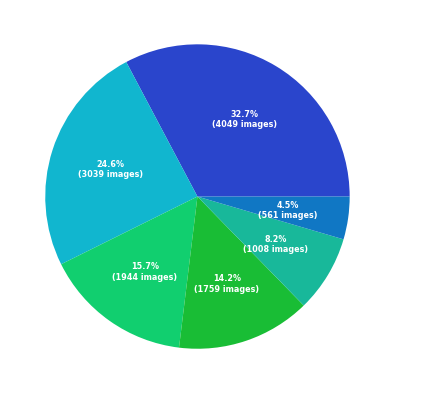

In [251]:
colors = ("#2A45CC", "#11B6CF","#11CF6F",
          "#19BD35", "#18B89A", "#1077C4") 

def get_percentages(pct, allvalues): 
    absolute = int(pct / 100.*sum(allvalues)) 
    return "{:.1f}%\n({:d} images)".format(pct, absolute) 
  
# Creating plot 
fig, ax = plt.subplots(figsize =(10, 7)) 
wedges, texts, autotexts = ax.pie(toc_df.medium.value_counts().values,  
                                  autopct = lambda pct: get_percentages(pct, list(toc_df.medium.value_counts().values)), 
                                  labels = toc_df.medium.value_counts().index,
                                  colors = colors,
                                  textprops = dict(color='white'),
                                  startangle = 0)
  
plt.setp(autotexts, size = 8, weight ="bold")
  
pie_path = fig_path / 'pie_distribution.png'
plt.savefig(pie_path, transparent=True)
plt.show()

filtering out offensive posts

In [265]:
offensive = find_submission_dict_by_id('jhdml2')['post']

In [266]:
offensive.upvote_ratio

0.33

it appears that all of these offensive posts (esspecially the ones that are simple screenshots of text) have upvote ratios of less than .4

by excluding any post with an upvote ratio of less than .4 I can be sure to get rid of all of these offensive posts, although it will cause me to drop some valid posts as well. I can't seem to find any other easy way of identifying the offensive posts so losing this handful of valid posts is acceptable to me seeing as some of these offensive posts are simply too grotesque to be left alone.

In [262]:
sum([table_of_contents[x]['post'].upvote_ratio for x in range(0, len(table_of_contents))]) / len(table_of_contents)

0.9066450986735334

In [268]:
downvoted_posts = [post for post in table_of_contents if post['post'].upvote_ratio < .4]

In [269]:
dvp_df = pd.DataFrame(downvoted_posts)

In [271]:
dvp_df.medium.value_counts()

digital            20
non_ink_drawing     8
paint               2
sculpture           1
ink                 1
Name: medium, dtype: int64

In [272]:
toc_df.medium.value_counts()

digital            4049
paint              3040
ink                1945
non_ink_drawing    1760
sculpture          1009
mixed_medium        561
Name: medium, dtype: int64

In [275]:
with os.scandir(dump_path) as d_scan:
    for file in d_scan:
        img_dict = next((x for x in table_of_contents if x['id'] == file.name[:-4]), None)
        if img_dict != None and img_dict['post'].upvote_ratio < .4:
            file_path = dump_path / file.name
            print(f'deleting {file.name}')
            os.remove(file_path)

for split in ['train', 'test', 'val']:
    for medium in ['digital', 'paint', 'ink', 'non_ink_drawing', 'sculpture']:
        medium_directory = data_path / 'tts' / split / medium
        with os.scandir(medium_directory) as d_scan:
            for file in d_scan:
                img_dict = next((x for x in table_of_contents if x['id'] == file.name[:-4]), None)
                if img_dict != None and img_dict['post'].upvote_ratio < .4:
                    file_path = medium_directory / file.name
                    print(f'deleting {file.name}')
                    os.remove(file_path)

deleting jpx9s0.png
deleting jlc59o.png
deleting jq6rhc.png
deleting jjcm4p.png
deleting ju1laz.png
deleting jsuclz.png
deleting jfp9ek.png
deleting jjlnxl.png
deleting jfw2o3.png
deleting jmdidm.jpg
deleting jeywop.png
deleting ijelan.jpg
deleting jfinfh.jpg
deleting jo8khk.jpg
deleting h0y1z6.jpg
deleting jnev84.jpg
deleting jtacn6.jpg
deleting jn43n9.jpg
deleting jqwa5y.png
deleting jttehe.jpg
deleting jfcqmt.png
deleting jhdml2.png
deleting jrku13.jpg
deleting jk66kg.jpg
deleting jfmdzf.jpg
deleting jnr3i2.jpg
deleting jvjap6.jpg
deleting jl53ad.jpg
deleting jg5xs9.jpg
deleting hzw3c2.jpg
deleting j9wu8s.jpg
deleting hekaaf.jpg


moving files from dump_path into binary_tts

In [283]:
binary_path = data_path / 'binary_tts'
btrain_path = binary_path / 'train'
binary_balance_train = get_dir_balance(btrain_path)
btest_path = binary_path / 'test'
binary_balance_test = get_dir_balance(btest_path)
bval_path = binary_path / 'val'
binary_balance_val = get_dir_balance(bval_path)
with os.scandir(dump_path) as d_scan:
    for file in d_scan:
        img_dict = next((x for x in table_of_contents if x['id'] == file.name[:-4]), None)
        if img_dict != None:
            if img_dict['medium'] == 'digital':
                if binary_balance_train['digital'] < 3000:
                    current_path = dump_path / file.name
                    new_path = binary_path / 'train' / 'digital'
                    shutil.move(str(current_path), str(new_path))
                    binary_balance_train['digital'] += 1
                elif binary_balance_test['digital'] < 100:
                    current_path = dump_path / file.name
                    new_path = binary_path / 'test' / 'digital'
                    shutil.move(str(current_path), str(new_path))
                    binary_balance_test['digital'] += 1
                elif binary_balance_val['digital'] < 100:
                    current_path = dump_path / file.name
                    new_path = binary_path / 'val' / 'digital'
                    shutil.move(str(current_path), str(new_path))
                    binary_balance_val['digital'] += 1
            else:
                if binary_balance_train['non_digital'] < 3000:
                    current_path = dump_path / file.name
                    new_path = binary_path / 'train' / 'non_digital'
                    shutil.move(str(current_path), str(new_path))
                    binary_balance_train['non_digital'] += 1
                elif binary_balance_test['non_digital'] < 100:
                    current_path = dump_path / file.name
                    new_path = binary_path / 'test' / 'non_digital'
                    shutil.move(str(current_path), str(new_path))
                    binary_balance_test['non_digital'] += 1
                elif binary_balance_val['non_digital'] < 100:
                    current_path = dump_path / file.name
                    new_path = binary_path / 'val' / 'non_digital'
                    shutil.move(str(current_path), str(new_path))
                    binary_balance_val['non_digital'] += 1
        print(f'train: {binary_balance_train} | test: {binary_balance_test} | val: {binary_balance_val}')

train: {'non_digital': 2085, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2085, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2086, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2086, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2087, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2087, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2087, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2087, 'digital': 795} | test: {'non_dig

train: {'non_digital': 2128, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2129, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2130, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2131, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2132, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2133, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2133, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2133, 'digital': 795} | test: {'non_dig

train: {'non_digital': 2155, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2156, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2156, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2157, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2158, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2159, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2159, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2160, 'digital': 795} | test: {'non_dig

train: {'non_digital': 2200, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2201, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2202, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2202, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2202, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2203, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2204, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2204, 'digital': 795} | test: {'non_dig

train: {'non_digital': 2224, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2224, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2224, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2225, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2225, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2226, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2227, 'digital': 795} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2227, 'digital': 795} | test: {'non_dig

train: {'non_digital': 2255, 'digital': 844} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2255, 'digital': 845} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2256, 'digital': 845} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2256, 'digital': 846} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2257, 'digital': 846} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2257, 'digital': 847} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2257, 'digital': 848} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2257, 'digital': 849} | test: {'non_dig

train: {'non_digital': 2272, 'digital': 888} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2272, 'digital': 889} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2272, 'digital': 889} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2272, 'digital': 889} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2272, 'digital': 890} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2272, 'digital': 891} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2272, 'digital': 892} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2273, 'digital': 892} | test: {'non_dig

train: {'non_digital': 2302, 'digital': 936} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2302, 'digital': 937} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2302, 'digital': 937} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2303, 'digital': 937} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2303, 'digital': 938} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2303, 'digital': 938} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2303, 'digital': 939} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2303, 'digital': 940} | test: {'non_dig

train: {'non_digital': 2325, 'digital': 968} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2325, 'digital': 969} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2326, 'digital': 969} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2327, 'digital': 969} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2328, 'digital': 969} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2328, 'digital': 970} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2328, 'digital': 970} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2328, 'digital': 971} | test: {'non_dig

train: {'non_digital': 2354, 'digital': 994} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2354, 'digital': 994} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2354, 'digital': 995} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2354, 'digital': 996} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2354, 'digital': 996} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2355, 'digital': 996} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2356, 'digital': 996} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2356, 'digital': 997} | test: {'non_dig

train: {'non_digital': 2391, 'digital': 1058} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2392, 'digital': 1058} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2392, 'digital': 1059} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2392, 'digital': 1060} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2392, 'digital': 1061} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2393, 'digital': 1061} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2393, 'digital': 1062} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2393, 'digital': 1063} | test: {

train: {'non_digital': 2416, 'digital': 1092} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2416, 'digital': 1093} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2417, 'digital': 1093} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2418, 'digital': 1093} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2419, 'digital': 1093} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2419, 'digital': 1094} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2419, 'digital': 1094} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2419, 'digital': 1095} | test: {

train: {'non_digital': 2444, 'digital': 1119} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2444, 'digital': 1120} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2445, 'digital': 1120} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2446, 'digital': 1120} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2447, 'digital': 1120} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2447, 'digital': 1120} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2448, 'digital': 1120} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2449, 'digital': 1120} | test: {

train: {'non_digital': 2476, 'digital': 1151} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2476, 'digital': 1151} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2477, 'digital': 1151} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2477, 'digital': 1152} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2477, 'digital': 1153} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2478, 'digital': 1153} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2479, 'digital': 1153} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2480, 'digital': 1153} | test: {

train: {'non_digital': 2515, 'digital': 1184} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2515, 'digital': 1185} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2515, 'digital': 1185} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2515, 'digital': 1186} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2516, 'digital': 1186} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2517, 'digital': 1186} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2518, 'digital': 1186} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2518, 'digital': 1187} | test: {

train: {'non_digital': 2545, 'digital': 1224} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2546, 'digital': 1224} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2547, 'digital': 1224} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2548, 'digital': 1224} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2549, 'digital': 1224} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2549, 'digital': 1224} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2549, 'digital': 1225} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2549, 'digital': 1226} | test: {

train: {'non_digital': 2578, 'digital': 1265} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2579, 'digital': 1265} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2580, 'digital': 1265} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2580, 'digital': 1266} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2581, 'digital': 1266} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2581, 'digital': 1267} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2581, 'digital': 1268} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2581, 'digital': 1269} | test: {

train: {'non_digital': 2614, 'digital': 1306} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2614, 'digital': 1306} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2615, 'digital': 1306} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2615, 'digital': 1307} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2615, 'digital': 1308} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2615, 'digital': 1309} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2616, 'digital': 1309} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2616, 'digital': 1310} | test: {

train: {'non_digital': 2647, 'digital': 1343} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2648, 'digital': 1343} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2648, 'digital': 1344} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2648, 'digital': 1344} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2648, 'digital': 1345} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2648, 'digital': 1345} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2649, 'digital': 1345} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2650, 'digital': 1345} | test: {

train: {'non_digital': 2681, 'digital': 1386} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2682, 'digital': 1386} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2682, 'digital': 1387} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2682, 'digital': 1388} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2682, 'digital': 1389} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2682, 'digital': 1390} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2683, 'digital': 1390} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2683, 'digital': 1391} | test: {

train: {'non_digital': 2723, 'digital': 1420} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2724, 'digital': 1420} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2724, 'digital': 1420} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2724, 'digital': 1421} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2725, 'digital': 1421} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2726, 'digital': 1421} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2727, 'digital': 1421} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2727, 'digital': 1422} | test: {

train: {'non_digital': 2778, 'digital': 1463} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2778, 'digital': 1464} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2779, 'digital': 1464} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2780, 'digital': 1464} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2781, 'digital': 1464} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2782, 'digital': 1464} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2782, 'digital': 1464} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2783, 'digital': 1464} | test: {

train: {'non_digital': 2809, 'digital': 1492} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2809, 'digital': 1493} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2810, 'digital': 1493} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2810, 'digital': 1494} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2811, 'digital': 1494} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2812, 'digital': 1494} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2812, 'digital': 1495} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2812, 'digital': 1496} | test: {

train: {'non_digital': 2837, 'digital': 1522} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2837, 'digital': 1522} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2837, 'digital': 1523} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2837, 'digital': 1524} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2837, 'digital': 1525} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2837, 'digital': 1526} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2838, 'digital': 1526} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2838, 'digital': 1527} | test: {

train: {'non_digital': 2887, 'digital': 1561} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2888, 'digital': 1561} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2888, 'digital': 1562} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2889, 'digital': 1562} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2890, 'digital': 1562} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2890, 'digital': 1563} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2890, 'digital': 1564} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2891, 'digital': 1564} | test: {

train: {'non_digital': 2930, 'digital': 1612} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2930, 'digital': 1613} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2930, 'digital': 1614} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2930, 'digital': 1614} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2931, 'digital': 1614} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2932, 'digital': 1614} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2933, 'digital': 1614} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2934, 'digital': 1614} | test: {

train: {'non_digital': 2995, 'digital': 1643} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2996, 'digital': 1643} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2996, 'digital': 1644} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2997, 'digital': 1644} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2997, 'digital': 1645} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2998, 'digital': 1645} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2998, 'digital': 1645} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 2999, 'digital': 1645} | test: {

train: {'non_digital': 3000, 'digital': 1684} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1684} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1684} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1685} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1685} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1685} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1685} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1686} | test: {

train: {'non_digital': 3000, 'digital': 1701} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1702} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1703} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1703} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1704} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1704} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1705} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1706} | test: {

train: {'non_digital': 3000, 'digital': 1767} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1767} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1767} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1767} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1768} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1769} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1770} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1771} | test: {

train: {'non_digital': 3000, 'digital': 1796} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1796} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1796} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1796} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1796} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1797} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1797} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1797} | test: {

train: {'non_digital': 3000, 'digital': 1825} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1825} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1825} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1825} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1825} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1826} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1827} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1828} | test: {

train: {'non_digital': 3000, 'digital': 1859} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1860} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1860} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1860} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1860} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1861} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1862} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1862} | test: {

train: {'non_digital': 3000, 'digital': 1898} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1898} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1898} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1898} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1898} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1898} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1898} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1899} | test: {

train: {'non_digital': 3000, 'digital': 1927} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1927} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1927} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1927} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1927} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1927} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1928} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1929} | test: {

train: {'non_digital': 3000, 'digital': 1968} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1969} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1970} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1970} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1970} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1971} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1971} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 1971} | test: {

train: {'non_digital': 3000, 'digital': 2004} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2004} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2004} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2004} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2004} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2004} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2004} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2004} | test: {

train: {'non_digital': 3000, 'digital': 2037} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2038} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2038} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2038} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2038} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2039} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2040} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2040} | test: {

train: {'non_digital': 3000, 'digital': 2067} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2067} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2067} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2068} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2069} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2069} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2069} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2069} | test: {

train: {'non_digital': 3000, 'digital': 2094} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2094} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2094} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2095} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2095} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2096} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2096} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2096} | test: {

train: {'non_digital': 3000, 'digital': 2131} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2131} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2132} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2133} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2133} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2133} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2133} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2133} | test: {

train: {'non_digital': 3000, 'digital': 2168} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2169} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2169} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2169} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2170} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2171} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2172} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2172} | test: {

train: {'non_digital': 3000, 'digital': 2196} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2196} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2196} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2196} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2197} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2197} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2197} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2197} | test: {

train: {'non_digital': 3000, 'digital': 2228} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2228} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2229} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2230} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2231} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2232} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2233} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2234} | test: {

train: {'non_digital': 3000, 'digital': 2263} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2264} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2264} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2264} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2264} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2265} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2265} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2266} | test: {

train: {'non_digital': 3000, 'digital': 2296} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2297} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2297} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2298} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2298} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2298} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2299} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2299} | test: {

train: {'non_digital': 3000, 'digital': 2321} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2321} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2321} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2321} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2322} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2322} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2322} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2322} | test: {

train: {'non_digital': 3000, 'digital': 2357} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2357} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2357} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2357} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2357} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2358} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2359} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2359} | test: {

train: {'non_digital': 3000, 'digital': 2386} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2386} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2387} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2388} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2389} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2389} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2389} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2389} | test: {

train: {'non_digital': 3000, 'digital': 2433} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2433} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2433} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2433} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2434} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2434} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2435} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2435} | test: {

train: {'non_digital': 3000, 'digital': 2469} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2470} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2471} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2471} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2472} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2472} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2473} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2473} | test: {

train: {'non_digital': 3000, 'digital': 2509} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2509} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2509} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2510} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2510} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2510} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2510} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2510} | test: {

train: {'non_digital': 3000, 'digital': 2542} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2542} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2543} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2543} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2544} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2545} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2545} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2546} | test: {

train: {'non_digital': 3000, 'digital': 2580} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2580} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2580} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2581} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2581} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2581} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2581} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2581} | test: {

train: {'non_digital': 3000, 'digital': 2600} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2600} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2600} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2600} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2600} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2600} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2600} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2600} | test: {

train: {'non_digital': 3000, 'digital': 2626} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2627} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2627} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2628} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2629} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2629} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2629} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2629} | test: {

train: {'non_digital': 3000, 'digital': 2647} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2648} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2648} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2648} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2648} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2648} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2648} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2648} | test: {

train: {'non_digital': 3000, 'digital': 2673} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2673} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2673} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2674} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2674} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2675} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2675} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2675} | test: {

train: {'non_digital': 3000, 'digital': 2699} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2699} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2699} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2699} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2700} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2700} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2700} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2700} | test: {

train: {'non_digital': 3000, 'digital': 2734} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2734} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2734} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2734} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2734} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2734} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2734} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2734} | test: {

train: {'non_digital': 3000, 'digital': 2759} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2760} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2760} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2760} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2760} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2761} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2761} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2762} | test: {

train: {'non_digital': 3000, 'digital': 2796} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2796} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2797} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2797} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2797} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2797} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2798} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2798} | test: {

train: {'non_digital': 3000, 'digital': 2823} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2823} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2823} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2823} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2823} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2823} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2824} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2824} | test: {

train: {'non_digital': 3000, 'digital': 2861} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2861} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2862} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2862} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2863} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2863} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2863} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2863} | test: {

train: {'non_digital': 3000, 'digital': 2898} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2899} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2899} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2899} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2899} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2899} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2900} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2901} | test: {

train: {'non_digital': 3000, 'digital': 2941} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2941} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2941} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2941} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2942} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2942} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2942} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2943} | test: {

train: {'non_digital': 3000, 'digital': 2971} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2971} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2972} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2972} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2972} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2972} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2972} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 2973} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {'non_digital': 100, 'digital': 101} | val: {'non_digital': 100, 'digital': 101}
train: {'non_digital': 3000, 'digital': 3000} | test: {

In [4]:
find_submission_dict_by_id('jn73cb')

NameError: name 'find_submission_dict_by_id' is not defined

In [1]:
def establish_binary_directory(directory_path):
    '''
    creates a directory structure to store the dataset
    
    Parameters:
        -- directory_path: a pathlib.path object where the directory is to be created
        
    Returns:
        None
    '''
    os.mkdir(str(directory_path / 'binary_tts'))
    for split in ['train', 'val', 'test']:
        os.mkdir(str(directory_path / 'binary_tts' / split))
        for category in ['digital', 'non_digital']:
            os.mkdir(str(directory_path / 'binary_tts' / split / category))

In [3]:
establish_binary_directory(data_path)

In [1]:
def download_and_store_binary(toc, store_path, ttvs):
    btrain_path = store_path / 'train'
    binary_balance_train = get_dir_balance(btrain_path)
    btest_path = store_path / 'test'
    binary_balance_test = get_dir_balance(btest_path)
    bval_path = store_path / 'val'
    binary_balance_val = get_dir_balance(bval_path)
    for category in ['digital', 'non_digital']:
        for post in toc:
            if post['medium'] == category:
                if binary_balance_train[category] < ttvs[0]:
                    download_path = btrain_path / category
                    download_image(post, download_path)
                elif binary_balance_test[category] < ttvs[1]:
                    download_path = btest_path / category
                    download_image(post, download_path)
                elif binary_balance_val[category] < ttvs[2]:
                    download_path = bval_path / category
                    download_image(post, download_path)

def download_image(post, path):
    response = requests.get(post['url'])
    file_name = f"{post['id']}.{post['url'][-3:]}"
    file_path = path / file_name
    file = open(str(file_path), "wb")
    file.write(response.content)
    file.close()